# The Second Part of the Assignment of IDS 2019-2020
Document your results as well as the way you obtained them in this jupyter notebook. Separate reports (pdf, word, etc.) are _not_ required. However, it is necessary that you provide the python code leading to your results as well as textual answers to the assignment questions in this notebook. *DO NOT CLEAR THE OUTPUT of the notebook you are submitting!* In the cases that the result of an algorithm is pdf, jpg, etc, you should attach the result to this notebook file and refer to that in the text.  

Next to the jupyter notebook, submit one zip-file containing all data sets that you are asked to submit. Make sure they are easily identifiable, i.e. use names as requested in the corresponding question.

Do not change the general structure of this notebook, but you can add further markdown or code cells to explain your solutions if necessary. In the end, submit this file and your created data sets in moodle.

Only <font color="red">one </font> group member should upload your group's solution.*Make sure to include group members' names and matriculation numbers*. If your name and student id are not included in the report, you will not receive any points!


Hint 1: While answering the questions, you will get a better and better impression of the given data. <font color="red"><b>Ensure that all claims you make are supported by the presented facts!</b></font>

Hint 2: <font color="red"><b>Some of the tasks might need some time to run. Take this into account in your planning.</b></font>

Hint 3: RWTHonline allows for multiple submissions (each submission overwrites the previous ones). <font color="red"><b>Partial submissions are possible and encouraged. </b></font> This helps in case of technical problems of RWTHonline, which do seldomly happen.

<font color="red"><b>Student Names and IDs:
    1. Matthew Judijanto - 394943
    2. Bruno Leong - 413183
    3. Philipp Noodt - 332565

In [321]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from mlxtend.preprocessing import minmax_scaling
from IPython.display import display, HTML # use display(df) to print df in beatiful table
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
import csv
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules as arule

import nltk
from nltk.corpus import stopwords
import string
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
from nltk.lm import MLE
from nltk.lm.preprocessing import padded_everygram_pipeline
from pm4py.objects.log.importer.xes import factory as xes_importer
from pm4py.objects.log.util import sorting
from pm4py.statistics.traces.log import case_statistics
from pm4py.algo.filtering.log.variants import variants_filter
from pm4py.algo.discovery.inductive import factory as inductive_miner
from pm4py.visualization.process_tree import factory as pt_vis_factory
from pm4py.algo.discovery.dfg import factory as dfg_factory
from pm4py.visualization.dfg import factory as dfg_vis_factory
from pm4py.algo.conformance.tokenreplay import factory as token_based_replay_factory
from pm4py.evaluation.replay_fitness import factory as replay_fitness_factory
from pm4py.visualization.petrinet import factory as pn_vis_factory



sns.set_style("darkgrid")

## Preprocessing of the Dataset (5 points)

The provided data set *air_pollution* contains hourly results of measuring the concentration of certain substances (CO, Benzene, NO2, particulate matter) and environmental conditions (temperature, relative humidity, traffic volume). This data was collected near a busy street in a city center by an automated device.

 You should carry out some preprocessing steps before starting the analysis:
 - Select 90% of 'air_pollution' dataset by random sampling. Use one of the group member's student number as a seed.
 - After completing this preprocessing step, export your final dataset as 'air_pollution_2.csv' dataset and use that for the next steps of the assignment.
 - If it is not directly mentioned, you should always use your extracted (above-created) dataset.
 - <font color='red'>Important!</font> Make sure that you submit your extracted dataset with your result in moodle.

In [230]:
#your code
# Read csv file air_pollution.csv
df = pd.read_csv('datasets/air_pollution.csv')

# Random sampling the data
df_sample = df.sample(frac=0.9, random_state = 394943)

# Print data to csv file
df_sample.to_csv('datasets/air_pollution_2.csv')
print("File created")

File created


## Question 1 - Data Preprocessing and Data Quality (10 points)

For this question, use the extracted data set you created in the preprocessing step ('air_pollution_2.csv'), but without the features *Traffic_Volume* and *Particulate_Matter*. Remove those columns before answering the questions.

In [231]:
#import libraries and data set
df2 = pd.read_csv('datasets/air_pollution_2.csv')

# Removing Traffic_Volume and Particulate_Matter
df2 = df2[df2.columns[:-2]]

(a) We want to get a first impression of the data. To achieve this, compute and show the following:
    - the column names (names of the features)
    - the data type of each feature
    - for time features: the minimum and maximum
    - for numerical (non-time) features: the mean, standard deviation, minimum and maximum
    - for categorical features: the number of classes and the value of the most frequent class

In [232]:
#your code

# Column names
print("Column names:")
print(df2.info(),"\n")

#inserting new columns for our modified features
df2.insert(8, 'Date_new', [0]*df2.shape[0], True)
df2.insert(9, 'Time_new', [0]*df2.shape[0], True)

for row in range(df2.shape[0]):
    df2.iloc[row, 8] = datetime.strptime(df2.iloc[row, 1], '%d.%m.%y')
    
    # checking, if there are 'Time' instances that contain information on minutes and seconds
    if ':00:00' not in df2.iloc[row, 2]:
        print('alert')
    df2.iloc[row, 9] = int(df2.iloc[row, 2].replace(':00:00', ''))

# Date and Time
print("Date min: ", df2['Date_new'].min().strftime('%d.%m.%y'))
print("Date max: ", df2['Date_new'].max().strftime('%d.%m.%y'))
print("Time min (hour of the day): ", df2['Time_new'].min())
print("Time max (hour of the day): ", df2['Time_new'].max(), "\n")

#deleting the freshly added columns
df2 = df2[df2.columns[:-2]]
display(df2[['CO', 'Benzene', 'NO2', 'Temperature', 'Humidity(%)']].describe())

Column names:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8421 entries, 0 to 8420
Data columns (total 8 columns):
Unnamed: 0     8421 non-null int64
Date           8421 non-null object
Time           8421 non-null object
CO             8421 non-null float64
Benzene        8421 non-null float64
NO2            8421 non-null int64
Temperature    8421 non-null float64
Humidity(%)    8421 non-null float64
dtypes: float64(4), int64(2), object(2)
memory usage: 526.4+ KB
None 

Date min:  10.03.04
Date max:  04.04.05
Time min (hour of the day):  0
Time max (hour of the day):  23 



,CO,Benzene,NO2,Temperature,Humidity(%)
count,8421.000000,8421.000000,8421.000000,8421.000000,8421.000000
mean,-34.098765,2.134473,58.427503,10.068709,39.761952
std,77.563195,40.773751,126.858152,42.581731,50.529104
min,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000
25%,0.600000,4.000000,53.000000,10.900000,34.100000
50%,1.500000,7.900000,96.000000,17.300000,48.500000
75%,2.600000,13.600000,133.000000,24.200000,61.800000
max,11.900000,63.700000,340.000000,44.600000,88.700000


Simply printing out the min and max of the time features causes misleading results, since they behave like data type string. (We understand both "Date" and "Time" features as time features. Of course, they could also be seen as categorical features, but we will treat both of them as time.) For instance: the minimum of the 'Date' feature is 01.01.05, while the maximum is 12.12.04. 
Therefore, we create new colums. First, we convert the entries of the 'Date' feature into datetime format in order to get minima and maxima for 'Date'. They algorithm will add information of hour, minute and second when printing out the minima and maxima. We will simply ignore them, knowing that they were artificially added. We then check, if the 'Time' instances contain information on minutes and seconds. Since they do not, we filter out the hour of the 'Time' feature in order to see which is the smallest and which is the greatest.

Since we treated both the 'Date' and the 'Time' feature as so called time features, there are no other categorical features in the dataset.

(b) Consider the features 'date' and 'time'. Combine them into a new column 'Datetime' using the datetime data type, and drop the old columns 'date' and 'time'. 

Which of the two representations of date and time do you think is more suitable for most analysis applications?

Explanation: 

For most application splitting date and time would be more convinience. By doing this we can easily choose to plot our data to be compared with time or date differently. Analysing the data either by time or date might produce an interesting trend to come out rather than if we plot the data versus the Datetime.

However the problem with our data is that the date and time columns has the "dtype: object". This is very inconvinience for us as it is difficult to extract each specific value from it, for instance if we just want the month from the date. By using the "dtype: Datetime64" we can take advantage of multiple function where we can extract specific temporal value from the data.

In [274]:
#your code

# Combine Date and Time into datetime
df2['Datetime'] = pd.to_datetime(df2['Date'].apply(str)+' '+df2['Time'], dayfirst=True)

# Drop columns Date and Time
df3 = df2.drop(['Date', 'Time'], axis=1)

display(df2.head())
display(df3.head())

,Unnamed: 0,Date,Time,CO,Benzene,NO2,Temperature,Humidity(%),Datetime
0,640,06.04.04,16:00:00,1.9,10.3,98,18.8,36.8,2004-04-06 16:00:00
1,9339,03.04.05,22:00:00,1.6,5.8,153,15.5,49.0,2005-04-03 22:00:00
2,2636,28.06.04,16:00:00,1.8,11.6,130,39.9,20.1,2004-06-28 16:00:00
3,757,11.04.04,13:00:00,1.1,4.0,70,22.3,22.4,2004-04-11 13:00:00
4,7292,08.01.05,13:00:00,2.8,13.1,147,13.8,50.9,2005-01-08 13:00:00


,Unnamed: 0,CO,Benzene,NO2,Temperature,Humidity(%),Datetime
0,640,1.9,10.3,98,18.8,36.8,2004-04-06 16:00:00
1,9339,1.6,5.8,153,15.5,49.0,2005-04-03 22:00:00
2,2636,1.8,11.6,130,39.9,20.1,2004-06-28 16:00:00
3,757,1.1,4.0,70,22.3,22.4,2004-04-11 13:00:00
4,7292,2.8,13.1,147,13.8,50.9,2005-01-08 13:00:00


(c) For each feature corresponding to a measured value, provide a simple scatter plot showing the data points over time. Can you spot any obvious data quality issues, e.g. inconsistencies, implausible values or missing values (without researching on specific domain knowledge)?

*Hint: you may perform additional computations to verify your findings.*

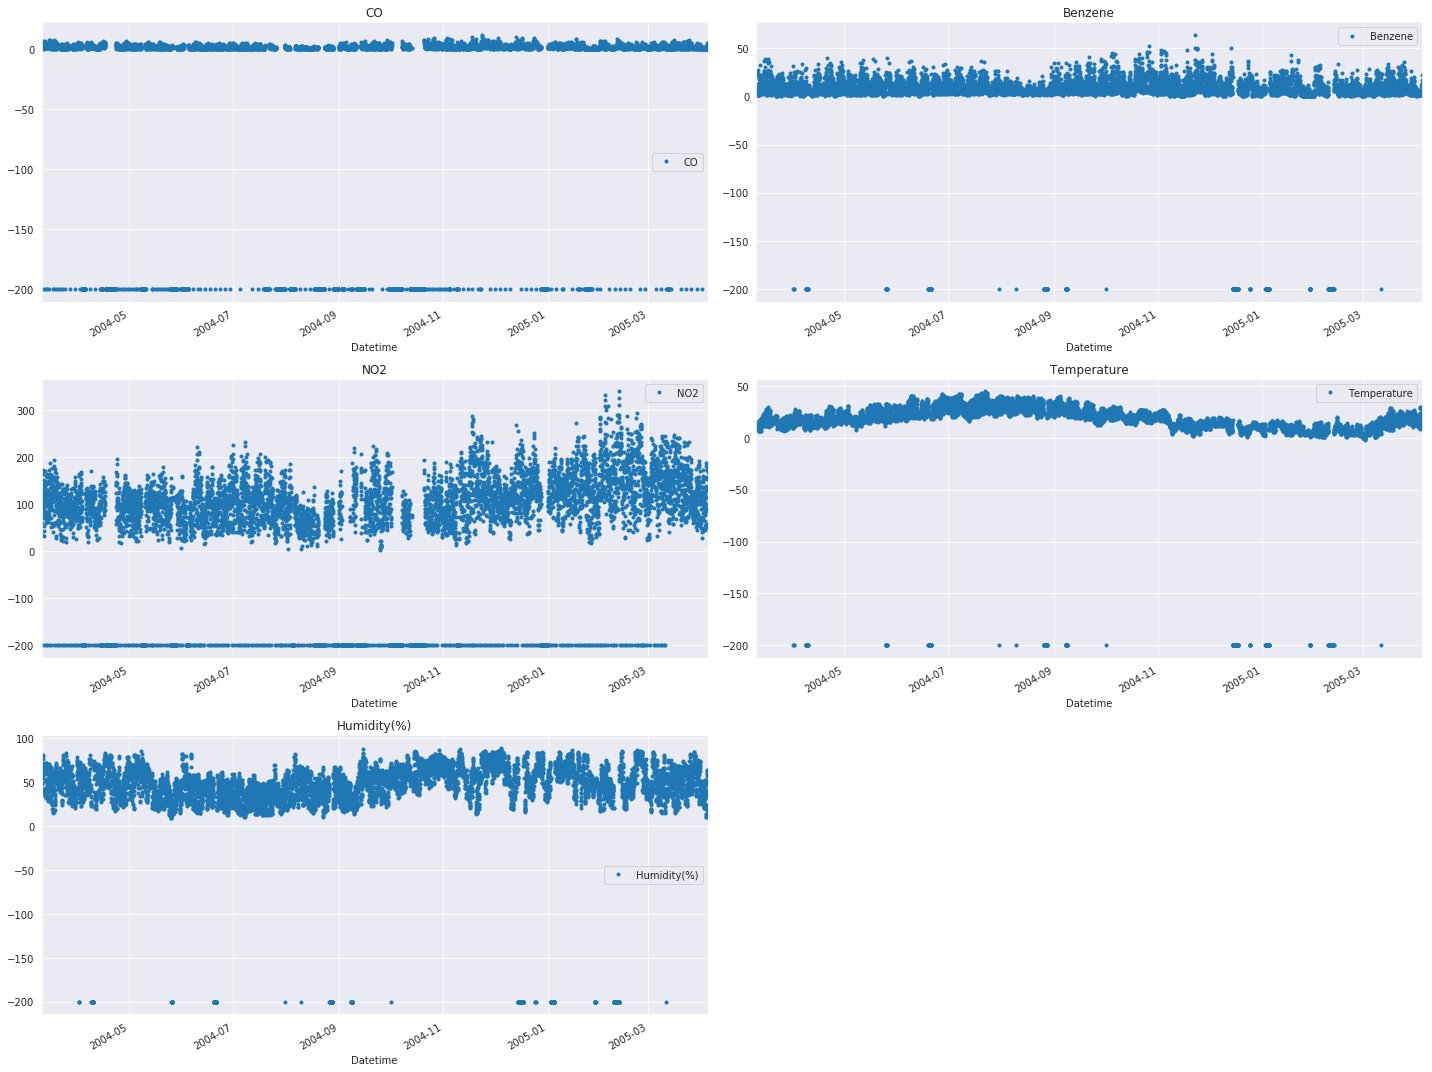

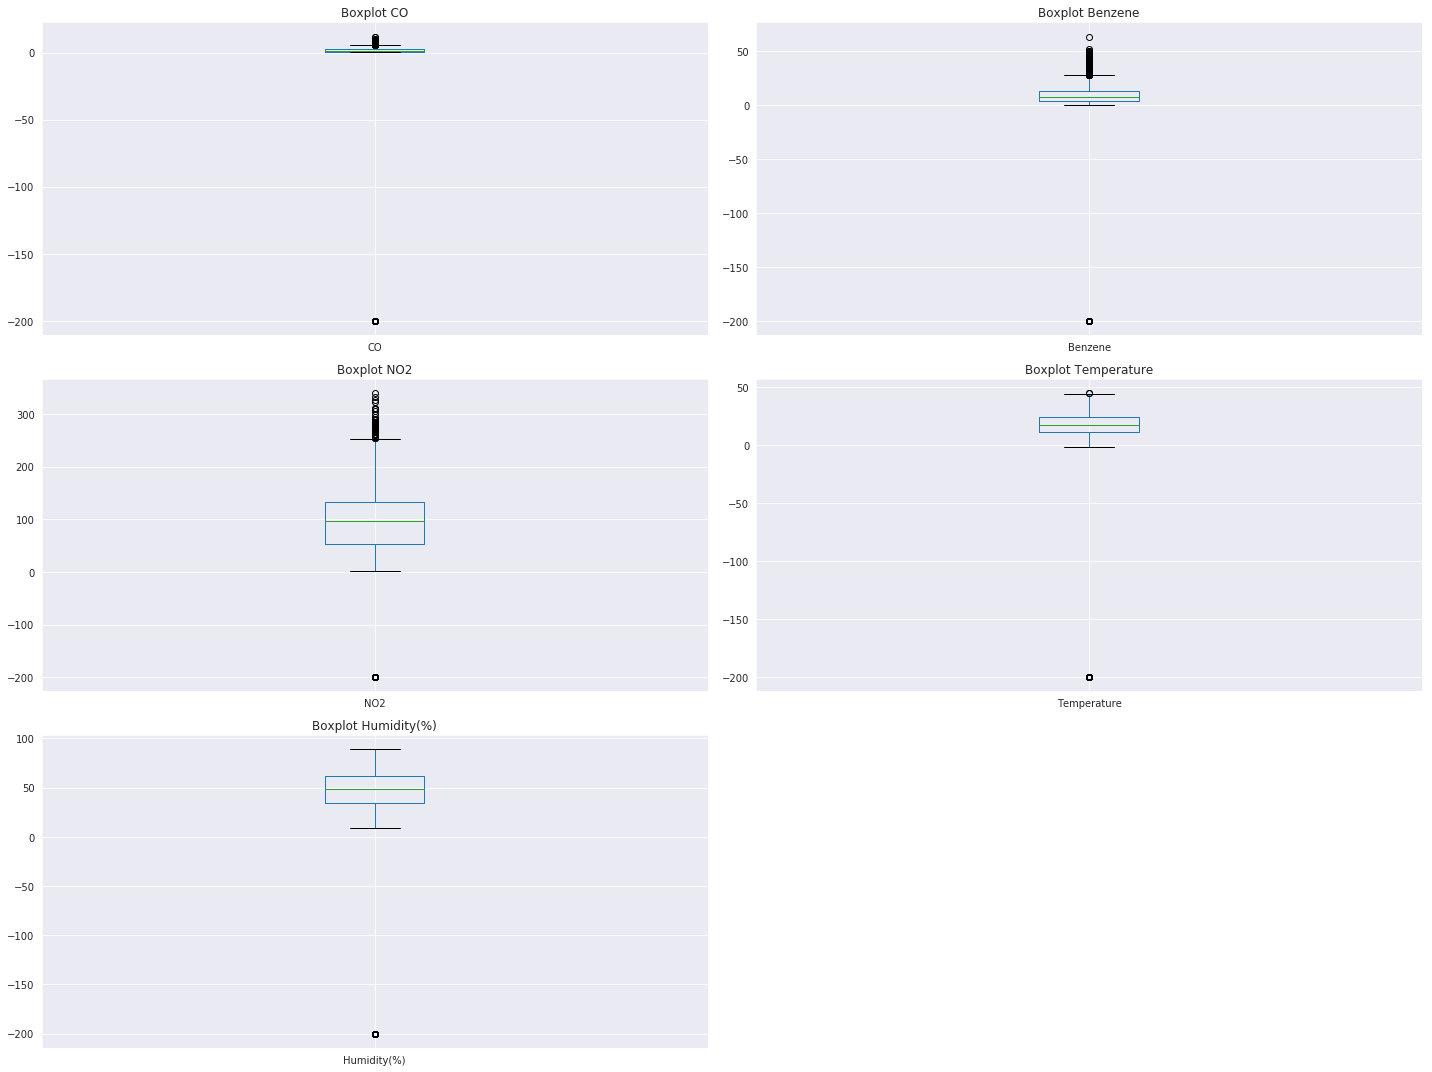

In [289]:
#your code

# Set Datetime as index
df4 = df3.set_index(pd.DatetimeIndex(df3['Datetime']))

# Drop columns Datetime and Unnamed: 0 -> not used
df4 = df4.drop(['Datetime', 'Unnamed: 0'], axis=1)

# Scatter Plot
fig1, axs1 = plt.subplots(3, 2, figsize=(20,15))
df4.plot(y=["CO"], ax=axs1[0, 0], style=".", title="CO")
df4.plot(y=["Benzene"], ax=axs1[0, 1], style=".", title="Benzene")
df4.plot(y=["NO2"], ax=axs1[1, 0], style=".", title="NO2")
df4.plot(y=["Temperature"], ax=axs1[1, 1], style=".", title="Temperature")
df4.plot(y=["Humidity(%)"], ax=axs1[2, 0], style=".", title="Humidity(%)")
fig1.delaxes(axs1[2, 1])
plt.tight_layout()

# Box Plot
fig2, axs2 = plt.subplots(3, 2, figsize=(20,15))
df4.plot(y=["CO"], ax=axs2[0, 0], kind="box", title="Boxplot CO")
df4.plot(y=["Benzene"], ax=axs2[0, 1], kind="box", title="Boxplot Benzene")
df4.plot(y=["NO2"], ax=axs2[1, 0], kind="box", title="Boxplot NO2")
df4.plot(y=["Temperature"], ax=axs2[1, 1], kind="box", title="Boxplot Temperature")
df4.plot(y=["Humidity(%)"], ax=axs2[2, 0], kind="box", title="Boxplot Humidity(%)")
fig2.delaxes(axs2[2, 1])
plt.tight_layout()

Explanation: 

Just based on the scatter plot we can see that each columns have outliers in the data. Using he the boxplot, we confirm the existence of the outliers since we have points outside the range of the box and whisker. The most notable outliers are those with the value of -200.

Another thing that we can see from the scatter plot is that there are some inconsistency in the amount of date for certain dates. This can be seen in the form of gap in between the data on different dates. For instance, the graph 'CO' and 'NO2', we can clearly see that there are gaps of data, where the density is not the same. Normally, the distribution of data remain consistent.

(d) We need to handle any implausible or missing data. In the lecture, several strategies to do so have been introduced, for example, deleting data rows that contain missing/implausible values or replacing them by a value derived from other data points. 

In this question, consider implausible values to be the ones identified in question (c).

    1) For all numerical features, compute and show mean, standard deviation, minimum and maximum, while ignoring the missing and implausible values. Also, print the total number of data rows.
    
    2) Choose a strategy (or combination of strategies) to handle missing/implausible values. Create a cleaned data set with all those values handled accordingly.
    
    3) For all numerical features, compute and show mean, standard deviation, minimum and maximum with respect to your cleaned data set. Also print the total number of data rows.
    
    4) Motivate and explain your strategy and describe its (dis-)advantages compared to other options. Compare the computed statistical values before and after cleaning and briefly describe and evaluate any changes.

Before Cleaning:


,CO,Benzene,NO2,Temperature,Humidity(%)
count,8421.000000,8421.000000,8421.000000,8421.000000,8421.000000
mean,-34.098765,2.134473,58.427503,10.068709,39.761952
std,77.563195,40.773751,126.858152,42.581731,50.529104
min,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000
25%,0.600000,4.000000,53.000000,10.900000,34.100000
50%,1.500000,7.900000,96.000000,17.300000,48.500000
75%,2.600000,13.600000,133.000000,24.200000,61.800000
max,11.900000,63.700000,340.000000,44.600000,88.700000


After Cleaning:


,CO,Benzene,NO2,Temperature,Humidity(%)
count,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000
mean,2.016117,9.724467,110.825167,17.837000,48.590133
std,1.182604,6.201425,44.823451,8.923671,17.529061
min,0.100000,0.200000,2.000000,-1.900000,9.200000
25%,1.100000,4.800000,78.000000,11.200000,34.900000
50%,1.800000,8.400000,108.000000,16.900000,48.600000
75%,2.700000,13.800000,138.000000,23.900000,62.000000
max,5.600000,28.000000,253.000000,43.400000,88.700000


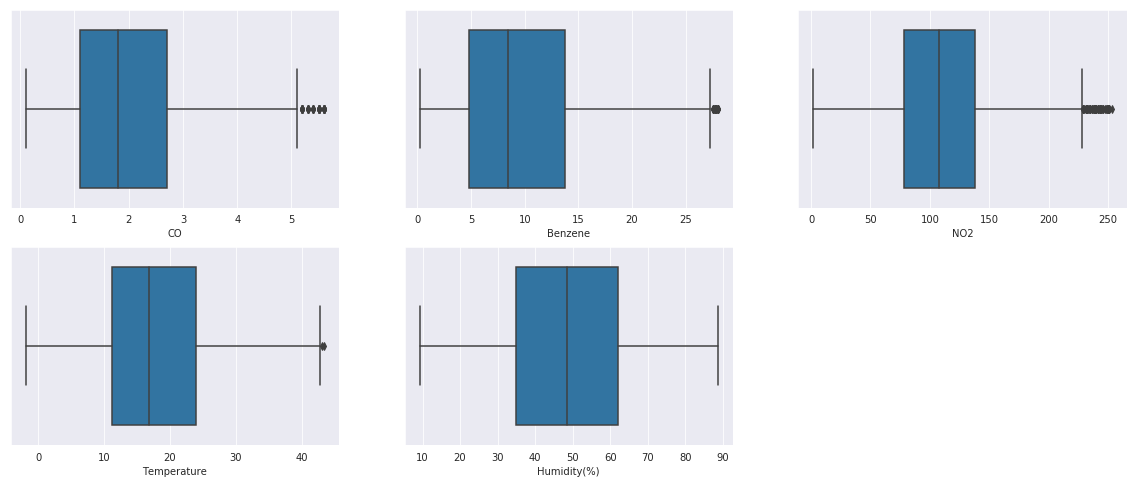

In [290]:
#your code
print("Before Cleaning:")
display(df2[['CO', 'Benzene', 'NO2', 'Temperature', 'Humidity(%)']].describe())

Q1 = df2[['CO', 'Benzene', 'NO2', 'Temperature', 'Humidity(%)']].quantile(0.25)
Q3 = df2[['CO', 'Benzene', 'NO2', 'Temperature', 'Humidity(%)']].quantile(0.75)
IQR = Q3 - Q1

df_clean = df2[~((df2[['CO', 'Benzene', 'NO2', 'Temperature', 'Humidity(%)']] < (Q1 - 1.5 * IQR)) |
                 (df2[['CO', 'Benzene', 'NO2', 'Temperature', 'Humidity(%)']] > (Q3 + 1.5 * IQR))).any(axis=1)]

print("After Cleaning:")
display(df_clean[['CO', 'Benzene', 'NO2', 'Temperature', 'Humidity(%)']].describe())

plt.figure(figsize=[20,8])
plt.subplot(2,3,1)
sns.boxplot(df_clean['CO'])
plt.subplot(2,3,2)
sns.boxplot(df_clean['Benzene'])
plt.subplot(2,3,3)
sns.boxplot(df_clean['NO2'])
plt.subplot(2,3,4)
sns.boxplot(df_clean['Temperature'])
plt.subplot(2,3,5)
sns.boxplot(df_clean['Humidity(%)'])

Explanation: 

Since we know that we have outliers, we can remove these outliers using 1.5 of the IQR. This 1.5 is just a rule of thumb but most of the time it can remove most of the outliers. Doing this method is simple and fast. However, removing data might affect our analyzation since we might lose important data from the other columns. But for our case, the amount that we remove is about 30% of the total amount of data, which is quite acceptable in our opinion.

If we choose to replace these implausible values by deriving it from other values, it might result in a totally different analyzation cause in the first place we don't even know whether or not the derived values is correct or not.

## Question 2 - Data Preprocessing  and Advanced Visualization (15 points)

For this question, use the extracted data set you created in the preprocessing step ('air_pollution_2.csv').

(a) To create a suitable input for the following questions, modify the data set as listed below and then print the first 5 data rows:

    - Remove the columns 'Traffic_Volume' and 'Particulate_Matter'
    - Replace the columns 'Date' and 'Time' by a combined column 'Datetime' using the datetime data type
    - Restrict the data to the timeframe between 2004-04-01 and 2005-03-31
    - Drop all rows that contain a missing value or a value below -37
    
*Hint: You may be able to reuse some of your code or data sets created above.*

In [272]:
#your code
#import libraries and data set
df2 = pd.read_csv('datasets/air_pollution_2.csv')

# Removing Traffic_Volume and Particulate_Matter
df2 = df2[df2.columns[:8]]

# Combine Date and Time into datetime
df2['Datetime'] = pd.to_datetime(df2['Date'].apply(str)+' '+df2['Time'], dayfirst=True)

# Drop columns Date and Time
df3 = df2.drop(['Date', 'Time'], axis=1)

# Restricting the date between 2004-04-01 and 2005-03-31 which include the endpoint
mask = (df3['Datetime'] >= '2004-04-01') & (df3['Datetime'] <= '2005-03-31')
df4 = df3.loc[mask]

# Removing values lower than -37
df_clean = df4[~((df4[['CO', 'Benzene', 'NO2', 'Temperature', 'Humidity(%)']] < (-37))).any(axis=1)]

display(df_clean.head())

,Unnamed: 0,CO,Benzene,NO2,Temperature,Humidity(%),Datetime
0,640,1.9,10.3,98,18.8,36.8,2004-04-06 16:00:00
2,2636,1.8,11.6,130,39.9,20.1,2004-06-28 16:00:00
3,757,1.1,4.0,70,22.3,22.4,2004-04-11 13:00:00
4,7292,2.8,13.1,147,13.8,50.9,2005-01-08 13:00:00
5,7769,0.9,2.0,77,3.0,49.1,2005-01-28 02:00:00


(b) For temperature, humidity and CO compute the mean value for each month. Create two stream graphs based on this newly computed data, that visualize the change in temperature, CO and humidity over the months:

    1) For the first stream graph, simply use the mean values you computed for each month.
    
    2) For the second stream graph, first normalize the computed mean values by mapping them individually to an interval between 0 and 1, that is, apply Min-max normalization.

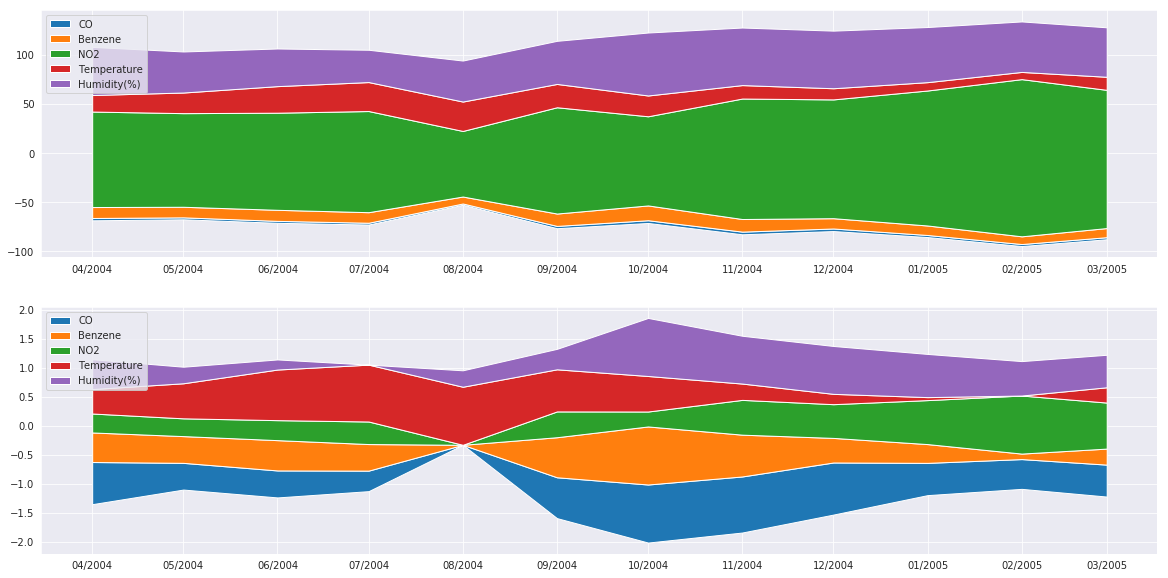

In [273]:
#your code
# Drop column Unnamed: 0
df_clean2 = df_clean.drop(['Unnamed: 0'], axis=1)

# Set Datetime as index
df_clean3 = df_clean2.set_index(pd.DatetimeIndex(df_clean['Datetime']))

# Resample/groupby data with month and count the mean
df_mean = df_clean3.resample('M').mean()

# Normalize the mean in between 0 and 1
df_normalize = minmax_scaling(df_mean, columns=['CO', 'Benzene', 'NO2', 'Temperature', 'Humidity(%)'])


# Create DatetimeIndex where the date is the first date of the month instead of the end date of the month
# Why I do this?
# Because if we use the regular DatetimeIndex, after the resample the date will be the end of the month
# For example '2004-04-30'
# this mean that when I plot it, the point will be close to 2004-05-01 and this is very difficult to discern on the plot
df_mean['Date_2'] = pd.to_datetime(df_mean.index)
df_mean['Datetime'] = df_mean.Date_2.map(lambda x: x.strftime('%Y-%m'))
df_mean2 = df_mean.set_index(pd.DatetimeIndex(df_mean['Datetime'])) 
df_mean2 = df_mean2.drop(['Date_2', 'Datetime'], axis=1)

# Plot Streamgraph
# Plot Mean
labels = ["CO", "Benzene", "NO2", "Temperature", "Humidity(%)"]
fig, ax = plt.subplots(2, figsize=(20,10))
ax[0].stackplot(df_mean2.index, df_mean['CO'], df_mean['Benzene'], df_mean['NO2'], df_mean['Temperature'], 
              df_mean['Humidity(%)'], labels=labels, baseline='wiggle')
ax[0].legend(loc='upper left')
ax[0].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax[0].xaxis.set_major_formatter(DateFormatter("%m/%Y"))

# Plot normalized mean
ax[1].stackplot(df_mean2.index, (df_normalize['CO'], df_normalize['Benzene'], df_normalize['NO2'], 
              df_normalize['Temperature'], df_normalize['Humidity(%)']), labels=labels, baseline='wiggle')
ax[1].legend(loc='upper left')
ax[1].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax[1].xaxis.set_major_formatter(DateFormatter("%m/%Y"))

(c) Answer the following questions based on the stream graphs created in question 2(a) and briefly explain how you derived the answer. Which of the two stream graphs do you consider more adequate to obtain the answers?

    1) In which month is the average CO lowest?
    
    2) Is there any correlation between humidity and CO?
    
    3) Between which months is temperature increasing?

Explanation:

-> Deriving the answers from this plot is a little bit tricky since stackplot works a little bit differently than a streamgraph. In stackplot, the value of each columns are added together to produce the y-axis value. So to deduce a value, we need to see the width of a certain category. We can do this by see the y-axis value of our current column and the deducting it with the y-axis value under it.

If we use the regular streamgraph, we can actully just use the y-axis immediately as the value.

    1) August 2004 has the lowest CO. This can be seen from the graph that it has the deepest valley.
    
    2) There is a correlation between humidity and CO since both always has the same contour.
        
    3) There is an increase in the temperature between April 2004 and August 2004. Another increase between February 2005 and March 2005.

(d) We want to create a heat map that visualizes the CO measured for different combinations of humidity and temperature. 
The heatmap should have 12 columns and 12 rows. The shown CO value should be the *median* of all values for the combination of humidity and temperature.

Modify the data as needed. Use a binning strategy of your choice for converting numerical data to categorical data. Motivate and explain all your choices and modifications.

In [302]:
#your code
# Drop column Unnamed: 0
df_clean2 = df_clean.drop(['Unnamed: 0'], axis=1)

# Set Datetime as index
df_clean3 = df_clean2.set_index(pd.DatetimeIndex(df_clean['Datetime']))

df_test = df_clean3

bin_label = ["1","2","3","4","5","6","7","8","9","10","11","12"]

df_test['Temp'] = pd.cut(df_clean3['Temperature'], bins=12, labels=bin_label)
df_test['Hum'] = pd.cut(df_clean3['Humidity(%)'], bins=12, labels=bin_label)
df_test['Temp_bin'] = pd.cut(df_clean3['Temperature'], bins=12)
df_test['Hum_bin'] = pd.cut(df_clean3['Humidity(%)'], bins=12)

print(df_test['Temp_bin'].value_counts().sort_index())
print(df_test['Hum_bin'].value_counts().sort_index())

# Checking for NaNs in the dataset
df_nan = df_test[df_test.isna().any(axis=1)]
if df_nan.empty == True:
    print('There are no NaNs in the dataset')
else:
    print('The dataset contains NaNs')


(-1.945, 1.875]     54
(1.875, 5.65]      430
(5.65, 9.425]      623
(9.425, 13.2]      928
(13.2, 16.975]     975
(16.975, 20.75]    836
(20.75, 24.525]    778
(24.525, 28.3]     598
(28.3, 32.075]     306
(32.075, 35.85]    248
(35.85, 39.625]    172
(39.625, 43.4]      52
Name: Temp_bin, dtype: int64
(9.12, 15.825]     108
(15.825, 22.45]    341
(22.45, 29.075]    509
(29.075, 35.7]     637
(35.7, 42.325]     673
(42.325, 48.95]    762
(48.95, 55.575]    756
(55.575, 62.2]     739
(62.2, 68.825]     614
(68.825, 75.45]    430
(75.45, 82.075]    340
(82.075, 88.7]      91
Name: Hum_bin, dtype: int64
There are no NaNs in the dataset


Our strategy for binning the dataset is just to do an automatic binning with 12 bins. With this, the bin range values will be evenly distributed and we can see more apparent whether there are any correlation for specific range of the values.

There are 4 new columns called Temp, Hum, Temp_bin, and Hum_bin. Column Temp and Hum are to be used for heatmap. They're the binned version of column Temperature and Humidity(%). There are 12 bins labelled 1 to 12. In order to know what these labels represent, we made a new columns called Temp_bin and Hum_bin just so we know what is the value for each respective label. We do this because if we use the binning value directly for the heatmap, somehow the heatmap can't be created and throws out and error. But if we relabelled the bin, we can use it for the heatmap. Until this submission, we don't know the solution for this.

(e) Use the modified data to create a heat map as specified in question part (c). Answer the following questions based on that heat map and briefly explain how you derived your answer:

    1) For which combination of humidity and temperature values is the median CO highest? 
    
    2) How do you explain empty fields in your heat map?
    
    3) Is CO correlating with temperature, humidity, or both?

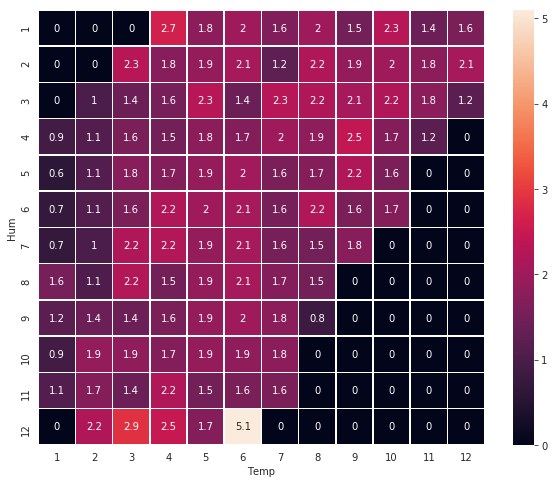

In [301]:
#your code

df_new = pd.pivot_table(df_test, index='Hum', columns='Temp', values='CO', aggfunc=np.median, fill_value=0)

# Plot Heatmap
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(df_new, annot=True, linewidths=.5, ax=ax)

Explanation:

1) With humidity (82.075, 88.7] and temperature (16.975, 20.75] it has the highest CO of 5.1

2) The empty field in the heatmap means that for that combination of humidity and temperature, there is no correlation for the CO values

3) Based on the heatmap, there are barely any pattern that can be seen. Thus we conclude that there is no correlation between CO and humidity - temperature. There is only a small correlation between CO and temperature where in the 2 lower region of temperature, the CO is very low. Any other temperature region has higher CO value.

## Question 3 - Clustering (15 points): 

(a) For this question, use the extracted data set you created in the preprocessing step ('air_pollution_2.csv'). Use a scatter diagram to find the relation between the 'Traffic_Volume' and 'Particulate_Matter' columns.

Text(0.5, 1.0, 'Scatter diagram')

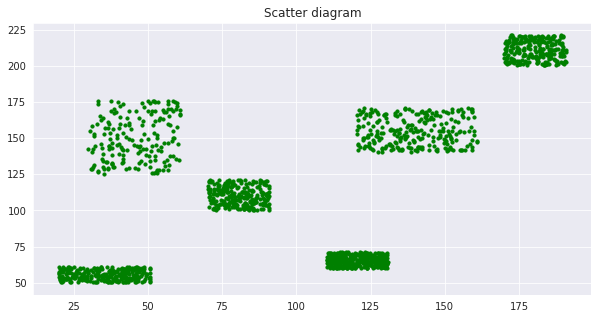

In [303]:
# Your code
df3 = pd.read_csv('datasets/air_pollution_2.csv')

#Scatter diagram that shows the relation between traffic_volume and particulate_matter
plt.rcParams['figure.figsize'] = (10, 5)
plt.scatter(df3['Traffic_Volume'], df3['Particulate_Matter'], c='green', s =10)
plt.title('Scatter diagram')

(b) From the previous question you found the relationship between two columns which are suitable for applying clustering methods. Find the two arrays corresponding to these to columns and drop nan values from them. Apply the k_means method for clustering the two mentioned columns. Use three different number of clusters for classifying.

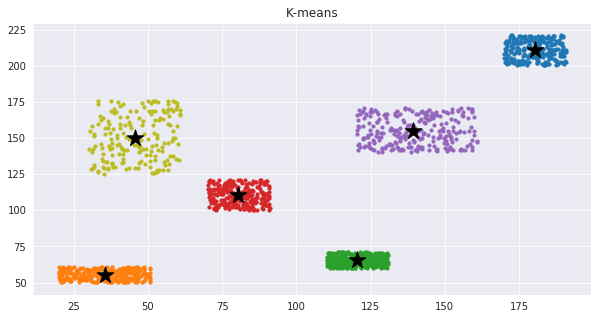

Number of clusters:  6


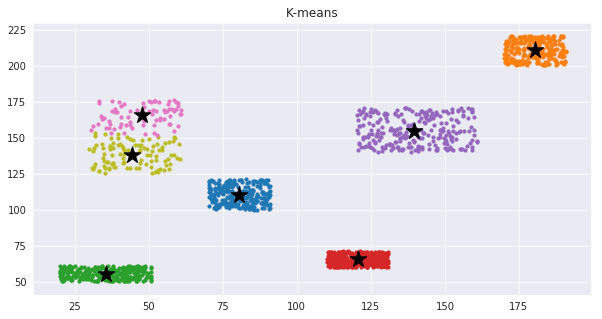

Number of clusters:  7


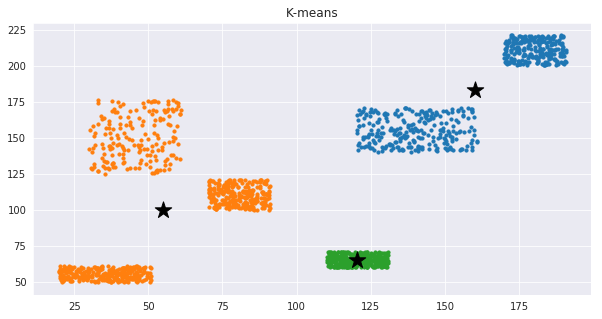

Number of clusters:  3


In [305]:
# Your code

#Arrays corresponding to the columns traffic_volume and particulate_matter
Traffic_V = df3['Traffic_Volume'].values
Particulate_M= df3['Particulate_Matter'].values

#Dropping the NaN values from the arrays
Data_NaN = np.array(list(zip(Traffic_V, Particulate_M)))
Data = Data_NaN[~np.isnan(Data_NaN).any(axis=1)]

#K-Means algorithm
list_cluster_num = [6,7,3]
for num_clusters in list_cluster_num:
    kmeans = KMeans(num_clusters).fit(Data)
    clusters = kmeans.labels_
    centroids = kmeans.cluster_centers_
    
    plt.rcParams['figure.figsize'] = (10, 5)
    fig, plots = plt.subplots()
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:olive', 'tab:pink', 'tab:brown', 'tab:cyan', 'tab:gray']
    for cluster_index in range(num_clusters) :
        sub_set = np.array([Data[i] for i in range(len(Data)) if clusters[i] == cluster_index])
        if len(sub_set) == 0 :
            continue
        plots.scatter(sub_set[:,0], sub_set[:,1], s = 10, c = colors[cluster_index])
    plots.scatter(centroids[:,0], centroids[:,1], marker = '*', s = 300, c = 'k')
    plt.title('K-means')
    plt.show()
    print('Number of clusters: ', num_clusters)

(c) Apply the DBSCAN method for clustering the two mentioned columns. Use three different eps and min_samples for clustering.

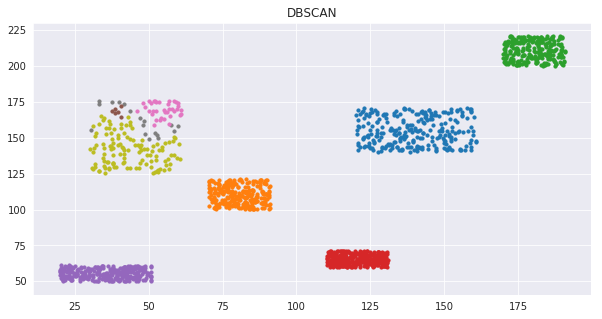

eps:  4 , min_samples:  5


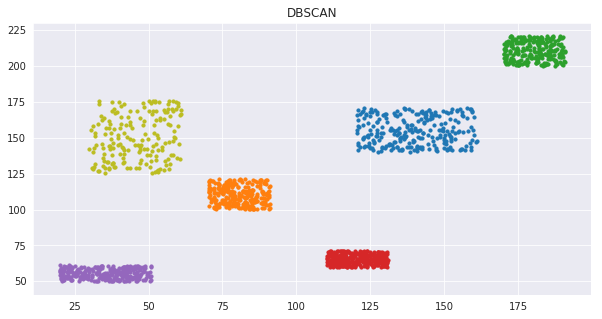

eps:  5 , min_samples:  4


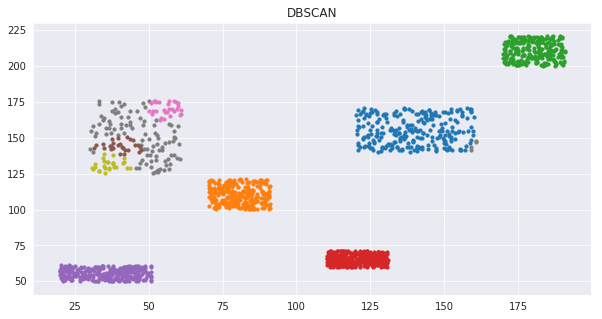

eps:  6 , min_samples:  18


In [307]:
# Your code

#DBSCAN algorithm
list_eps = [4,5,6]
list_samples = [5,4,18]
for (num_eps, num_samples) in zip(list_eps, list_samples):
    dbscan = DBSCAN(eps=num_eps, min_samples=num_samples).fit(Data)
    clusters = dbscan.labels_
    cluster_indexs = np.unique(clusters).tolist()

    fig, plots = plt.subplots()
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:olive', 'tab:pink', 'tab:brown', 'tab:cyan', 'tab:gray']
    for cluster_index in cluster_indexs :
        sub_set = np.array([Data[i] for i in range(len(Data)) if clusters[i] == cluster_index])
        if len(sub_set) == 0:
            continue
        plots.scatter(sub_set[:,0], sub_set[:,1], s = 10, c = colors[cluster_index])
    plt.title('DBSCAN')
    plt.show()
    print('eps: ', num_eps, ', min_samples: ', num_samples)

(d) Compare k_means and DBSCAN results. Which of these methods is more suitable for clustering this data? Why?

In [ ]:
# Your code

Explanation:

Through the scatter diagram that was plotted for the variables Traffic_Volume and Particulate_Matter from the air_pollution dataset, we can already see that there are not any visible outliers in this relationship and that there are six simple rectangular shaped clusters. The best clustering method for this data is K-means, because although K-means is very sensitive to outliers it was not a problem here since there did not seem to be any in this specific case, we already had an idea in advance of how many clusters we were detecting and the DBSCAN algorithm sometimes failed to identify clusters if the density within it varied a lot as can be seen for example when we defined eps as 6 and min_samples as 18.

(e) Add noise to the two mentioned columns. For adding noise, first find the range of these two columns and add a random number of 30 samples of noise in the range of each column to that. Plot the scatter diagram again.
Repeat k_means and DBSCAN algorithms for clustering. Which of these methods is more suitable for clustering this data? Why?

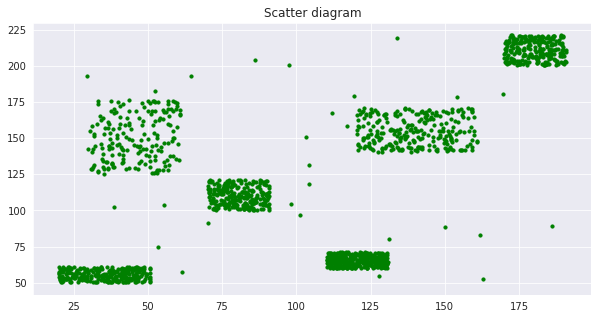

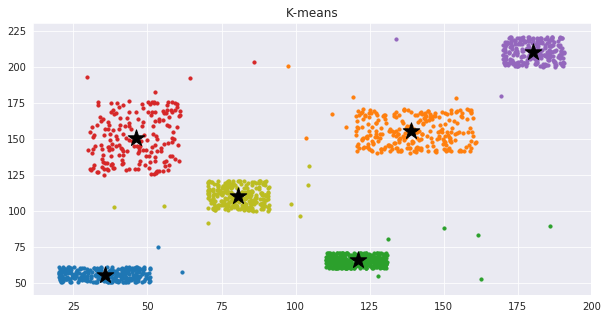

Number of clusters:  6


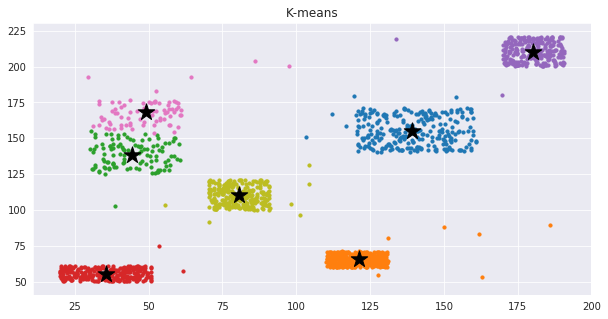

Number of clusters:  7


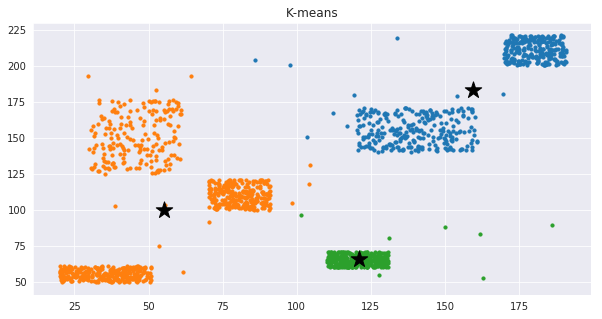

Number of clusters:  3


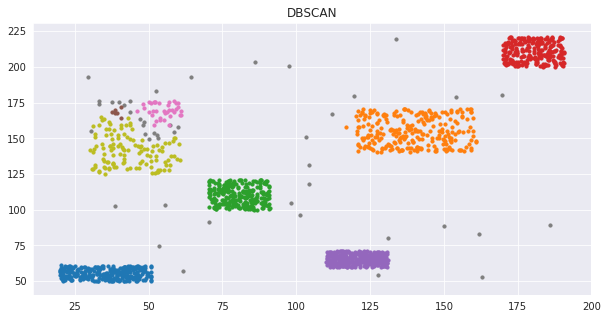

eps:  4 , min_samples:  5


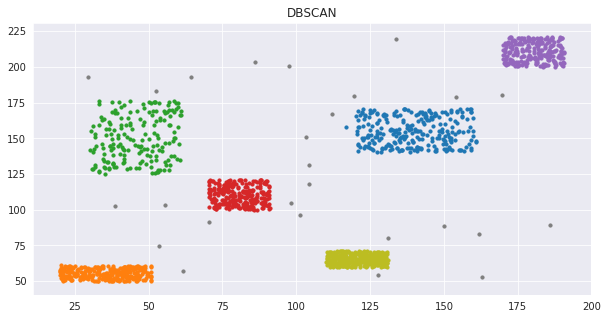

eps:  5 , min_samples:  4


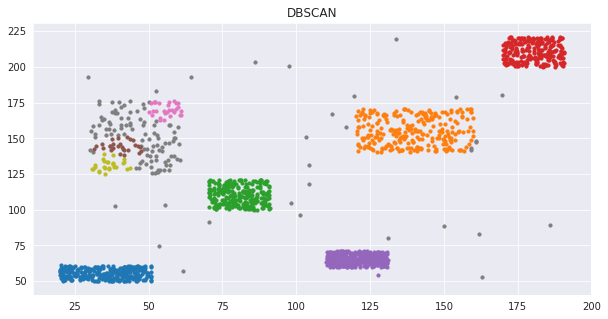

eps:  6 , min_samples:  18


In [310]:
# Your code

df3 = pd.read_csv('datasets/air_pollution_2.csv')

#Arrays corresponding to the columns traffic_volume and particulate_matter
Traffic_V = df3['Traffic_Volume'].values
Particulate_M= df3['Particulate_Matter'].values

#Adding 30 samples of noise to each of the arrays Traffic_V and Particulate_M
np.random.seed(394943)
Traffic_V2 = np.append((np.random.uniform(low=min(Traffic_V), high=max(Traffic_V), size=30)), Traffic_V)
Particulate_M2 = np.append((np.random.uniform(low=min(Particulate_M), high=max(Particulate_M), size=30)), Particulate_M)

#Dropping the NaN values from the arrays
Data_NaN2 = np.array(list(zip(Traffic_V2, Particulate_M2)))
Data2 = Data_NaN2[~np.isnan(Data_NaN2).any(axis=1)]

#Scatter diagram that shows the relation between traffic_volume and particulate_matter
plt.rcParams['figure.figsize'] = (10, 5)
plt.scatter(Traffic_V2, Particulate_M2, c='green', s =10)
plt.title('Scatter diagram')

#K-Means algorithm
list_cluster_num = [6,7,3]
for num_clusters in list_cluster_num:
    kmeans = KMeans(num_clusters).fit(Data2)
    clusters = kmeans.labels_
    centroids = kmeans.cluster_centers_
    
    plt.rcParams['figure.figsize'] = (10, 5)
    fig, plots = plt.subplots()
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:olive', 'tab:pink', 'tab:brown', 'tab:cyan', 'tab:gray']
    for cluster_index in range(num_clusters) :
        sub_set = np.array([Data2[i] for i in range(len(Data2)) if clusters[i] == cluster_index])
        if len(sub_set) == 0 :
            continue
        plots.scatter(sub_set[:,0], sub_set[:,1], s = 10, c = colors[cluster_index])
    plots.scatter(centroids[:,0], centroids[:,1], marker = '*', s = 300, c = 'k')
    plt.title('K-means')
    plt.show()
    print('Number of clusters: ', num_clusters)
    
#DBSCAN algorithm
list_eps = [4,5,6]
list_samples = [5,4,18]
for (num_eps, num_samples) in zip(list_eps, list_samples):
    dbscan = DBSCAN(eps=num_eps, min_samples=num_samples).fit(Data2)
    clusters = dbscan.labels_
    cluster_indexs = np.unique(clusters).tolist()

    fig, plots = plt.subplots()
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:olive', 'tab:pink', 'tab:brown', 'tab:cyan', 'tab:gray']
    for cluster_index in cluster_indexs :
        sub_set = np.array([Data2[i] for i in range(len(Data2)) if clusters[i] == cluster_index])
        if len(sub_set) == 0:
            continue
        plots.scatter(sub_set[:,0], sub_set[:,1], s = 10, c = colors[cluster_index])
    plt.title('DBSCAN')
    plt.show()
    print('eps: ', num_eps, ', min_samples: ', num_samples)

Explanation:

The best clustering method for this data is dbscan. With the addition of 30 samples of noise to this data, we can see that the K-means algorithm does not work well as it is very sensitive to outliers, can only capture clusters with spherical shapes and therefore is not able to capture the new cluster made up of noise. On the other hand, the dbscan algorithm is much more robust to noise and can capture clusters of complex shapes, more specifically in this case, the noise that is surrounding all the clusters but that is not connected to those clusters themselves.

## Question 4 - Frequent itemsets and association rules (15 points): 

(a) You should carry out some preprocessing steps before starting the analysis:
 - Select 90% of 'applications' dataset by random sampling. Use one of the group member's student number as a seed.
 - After completing this preprocessing step, export your final dataset as 'applications_2.csv' dataset and use that for the next steps of the assignment.
 - <font color='red'>Important!</font> Make sure that you submit your extracted dataset with your result in moodle.

In [313]:
# Your code

df = pd.read_csv('datasets/applications.csv')

# random sampling the data
df_dataset = df.sample(frac=0.9, random_state = 394943)

# Print data to csv file
df_dataset.to_csv('datasets/applications_2.csv', index=False, header=False)

# Checking for NaNs in the dataset
df_nan = df_dataset[df_dataset.isna().any(axis=1)]
if df_nan.empty == True:
    print('There are no NaNs in the dataset')
else:
    print('The dataset contains NaNs')

print("File created")

The dataset contains NaNs
File created


(b) Find the most frequent itemsets with the support of more than 0.4 by using the Apriori algorithm (Hint: When you are creating rows to make the data_set, you should use none_empty strings).

In [315]:
# Your code

df = pd.read_csv('datasets/applications_2.csv')

# Read data from file applications_2.csv 
data_set = []
with open("datasets/applications_2.csv") as csvFile:
    reader = csv.reader(csvFile)
    for row in reader:
        data_set.append([x for x in row if x])
        
# Show 3 first rows of data_set
print(data_set[0:3][:])

# Transform data_set into an array and then into a dataframe for Apriori algorithm in mlxtend
te = TransactionEncoder()
te_ary = te.fit(data_set).transform(data_set)
data = pd.DataFrame(te_ary, columns = te.columns_)
data.head(10)

# Apriori algorithm from mlxtend
frequent_itemsets = apriori(data, min_support = 0.4, use_colnames = True)
frequent_itemsets

[['A_SUBMITTED', 'A_PARTLYSUBMITTED', 'W_Afhandelen leads', 'W_Afhandelen leads', 'W_Afhandelen leads', 'W_Afhandelen leads', 'A_PREACCEPTED', 'W_Completeren aanvraag', 'W_Afhandelen leads', 'W_Completeren aanvraag', 'A_DECLINED', 'W_Completeren aanvraag'], ['A_SUBMITTED', 'A_PARTLYSUBMITTED', 'A_PREACCEPTED', 'W_Completeren aanvraag', 'W_Completeren aanvraag', 'W_Completeren aanvraag', 'W_Completeren aanvraag', 'A_ACCEPTED', 'A_FINALIZED', 'O_SELECTED', 'O_CREATED', 'O_SENT', 'W_Nabellen offertes', 'W_Completeren aanvraag', 'W_Nabellen offertes', 'W_Nabellen offertes', 'W_Nabellen offertes', 'W_Nabellen offertes', 'W_Nabellen offertes', 'W_Nabellen offertes', 'W_Nabellen offertes', 'W_Nabellen offertes', 'W_Nabellen offertes', 'W_Nabellen offertes', 'W_Nabellen offertes', 'W_Nabellen offertes', 'W_Nabellen offertes', 'W_Nabellen offertes', 'W_Nabellen offertes', 'W_Nabellen offertes', 'W_Nabellen offertes', 'W_Nabellen offertes', 'W_Nabellen offertes', 'O_SENT_BACK', 'W_Valideren aanv

,support,itemsets
0,0.583171,(A_DECLINED)
1,1.000000,(A_PARTLYSUBMITTED)
2,0.562282,(A_PREACCEPTED)
3,1.000000,(A_SUBMITTED)
4,0.562282,(W_Completeren aanvraag)
5,0.583171,"(A_PARTLYSUBMITTED, A_DECLINED)"
6,0.583171,"(A_SUBMITTED, A_DECLINED)"
7,0.562282,"(A_PREACCEPTED, A_PARTLYSUBMITTED)"
8,1.000000,"(A_SUBMITTED, A_PARTLYSUBMITTED)"
9,0.562282,"(W_Completeren aanvraag, A_PARTLYSUBMITTED)"


(c) Find the most frequent itemsets with the support of more than 0.4 by using the Apriori algorithm having more than 2 members.

In [316]:
# Your code

# Apriori algorithm from mlxtend with a support higher than 0.4
frequent_itemsets = apriori(data, min_support = 0.4, use_colnames = True)
#frequent_itemsets

# Add another column to frequent_itemsets which indicates the number of items in each frequent itemset.
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
#frequent_itemsets

# Filter frequent_itemsets which have a length higher than 2  
frequent_itemsets_filtered = frequent_itemsets.loc[(frequent_itemsets['length'] > 2)]   
frequent_itemsets_filtered

,support,itemsets,length
13,0.583171,"(A_PARTLYSUBMITTED, A_SUBMITTED, A_DECLINED)",3
14,0.562282,"(A_PREACCEPTED, A_SUBMITTED, A_PARTLYSUBMITTED)",3
15,0.562282,"(W_Completeren aanvraag, A_PREACCEPTED, A_PART...",3
16,0.562282,"(W_Completeren aanvraag, A_SUBMITTED, A_PARTLY...",3
17,0.562282,"(W_Completeren aanvraag, A_PREACCEPTED, A_SUBM...",3
18,0.562282,"(W_Completeren aanvraag, A_PREACCEPTED, A_SUBM...",4


(d) Find the itemsets having min_confidence=0.3 and min_lift=1.2. Print support, confidence and lift of filtered rules in one table.

In [318]:
# Your code

# Association rules
association_rules = arule(frequent_itemsets)

# Filtering the results by having confidence larger than 0.3 and lift larger than 0.2
filtered_rules = association_rules.loc[(association_rules['lift'] > 1.2) & (association_rules['confidence'] > 0.3)]   

# Show the columns 'support', 'confidence' and 'lift' of variable 'filtered_rules' 
filtered_rules[['support', 'confidence', 'lift']]


,support,confidence,lift
7,0.562282,1.0,1.778466
8,0.562282,1.0,1.778466
17,0.562282,1.0,1.778466
18,0.562282,1.0,1.778466
19,0.562282,1.0,1.778466
20,0.562282,1.0,1.778466
25,0.562282,1.0,1.778466
26,0.562282,1.0,1.778466
27,0.562282,1.0,1.778466
28,0.562282,1.0,1.778466


## Question 5 - Text Mining (15 points)

Among the datasets given for this assignment you will find the files "pg_train" and "pg_test". These two files contain a labeled corpus, already splitted in training and test set.
The corpus consists of sentences from several novels, labeled with the name of the author. The first task is text classification: you will train a set of classifiers that predict the author of a piece of text.

(a) Perform preprocessing on the training corpus (all lowercase, no punctuation, tokenization, stemming, stopword removal) and obtain a binary document-term matrix; train a logistic classifier with the author as target.

In [325]:
# Your code
# nltk.download('punkt')
# nltk.download('stopwords')

# read the csv and seperate documents, extract label
path = 'datasets/pg_train.csv'
corpus_train = pd.read_csv(path, sep='#', names=['Author', 'Text'], encoding='latin-1')

print('Authors in dataset: ', corpus_train.Author.unique())
print('Shape of dataframe: ', np.shape(corpus_train))

# Tokenization/Bag of Words Model -> Document-Term matrix
# building our own tokenizer, because scikitlearns codebase does not include a stemmer.
# we use the more aggresive snowball-stemmer
snowball_stemmer = SnowballStemmer('english', ignore_stopwords=True)
stoplist = set(stopwords.words('english'))

# here we tokenize, stem, remove punctuation and stopwords and convert uppercase to lowercase letters
def tokenize(doc):
    tokens = nltk.word_tokenize(doc.lower().translate(doc.maketrans('','',string.punctuation)))
    stems = [snowball_stemmer.stem(token) for token in tokens if token not in stoplist]
    return stems


# here we create the binary document term matrix
vectorizer_binary = CountVectorizer(lowercase=True, preprocessor=None, binary=True, stop_words=None,
                                    tokenizer=tokenize)
corpus = corpus_train.Text.values
labels = corpus_train.Author.values

X_train_counts = vectorizer_binary.fit_transform(corpus)
print(X_train_counts.shape)
print(type(X_train_counts))

# dict for kwargs of logistic regression (same for all 4 models for a better comparison)
regression_settings = {'solver': 'lbfgs',
                       'multi_class': 'ovr',  # ‘multinomial’: fits binary problem for all features
                       'max_iter': 800,
                       'tol': 0.00005,
                       }

print(regression_settings)

# create pipeline for preprocessing and binary regression -> same preprocesing done for test_set
binary_pipeline = Pipeline([('vect_bin', vectorizer_binary), 
                            ('log_reg', LogisticRegression(**regression_settings))])

binary_pipeline = binary_pipeline.fit(corpus, labels)

print('binary_pipeline finished')

Authors in dataset:  ['austen' 'chesterton' 'shakespeare']
Shape of dataframe:  (4499, 2)
(4499, 11527)
<class 'scipy.sparse.csr.csr_matrix'>
{'solver': 'lbfgs', 'multi_class': 'ovr', 'max_iter': 800, 'tol': 5e-05}
binary_pipeline finished


(b) Perform preprocessing on the training corpus (all lowercase, no punctuation, tokenization, stemming, stopword removal) and obtain a document-term matrix of counts; train a logistic classifier with the author as target.


In [326]:
# Your code

vectorizer_count = CountVectorizer(binary=False, lowercase=False, preprocessor=None, stop_words=None,
                                   tokenizer=tokenize)

count_pipeline = Pipeline([('vect_count', vectorizer_count), 
                           ('log_reg', LogisticRegression(**regression_settings))])

count_pipeline = count_pipeline.fit(corpus, labels)

print('count_pipeline finished')

count_pipeline finished


(c) Perform preprocessing on the training corpus (all lowercase, no punctuation, tokenization, stemming, stopword removal) and obtain a tf-idf scores document-term matrix; train a logistic classifier.


In [327]:
# Your code
from sklearn.feature_extraction.text import TfidfTransformer

vectorizer_count = CountVectorizer(binary=False, lowercase=False, preprocessor=None, stop_words=None,
                             tokenizer=tokenize)

# tf-idf transformer
tfidf_transformer = TfidfTransformer()

# added to pipeline
tfidf_pipeline = Pipeline([('vect_count', vectorizer_count), ('tf-idf', tfidf_transformer),
                      ('log_reg', LogisticRegression(**regression_settings))])

tfidf_pipeline = tfidf_pipeline.fit(corpus, labels)

print('tdidf_pipeline finished')

tdidf_pipeline finished


(d) Perform preprocessing on the training corpus (all lowercase, no punctuation, tokenization, stemming, stopword removal) and obtain a doc2vec embedding in order to reduce the dimension of the document vector to 300; use the doc2vec model you just trained to convert the training set to a set of document vectors; train a logistic classifier with the author as target.


In [328]:
# Your code
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# create list with tagged documents for training the Doc2Vec
tagged_data = [TaggedDocument(words=tokenize(doc), tags=[labels[i]]) for i, doc in enumerate(corpus)]

# Doc2Vec creation and training
model = Doc2Vec(documents=[doc_ for doc_ in tagged_data], vector_size=300, epochs=50,
                min_count=2, dm =1)
  
# examplary print 
print(tagged_data[1])


# preprocessing of training data for doc2vec model
corpus_doc2vec = [tokenize(doc) for doc in corpus]

# get vectors of size 300 from trained Doc2Vec model
doc2vec_train = [model.infer_vector(doc) for doc in corpus_doc2vec]

# train logistic regression
doc2vec_regressor = LogisticRegression(**regression_settings)
doc2vec_regressor.fit(doc2vec_train, labels)

print('doc2vec_regressor finished')

TaggedDocument(['sixteen', 'year', 'miss', 'taylor', 'mr', 'woodhous', 'famili', 'less', 'gover', 'friend', 'fond', 'daughter', 'particular', 'emma', 'intimaci', 'sister', 'even', 'miss', 'taylor', 'ceas', 'hold', 'nomin', 'offic', 'gover', 'mild', 'temper', 'hard', 'allow', 'impos', 'restraint', 'shadow', 'author', 'long', 'pass', 'away', 'live', 'togeth', 'friend', 'friend', 'mutual', 'attach', 'emma', 'like', 'high', 'esteem', 'miss', 'taylor', 'judgment', 'direct', 'chiefli', 'real', 'evil', 'inde', 'emma', 'situat', 'power', 'rather', 'much', 'way', 'disposit', 'think', 'littl', 'well', 'disadvantag', 'threaten', 'alloy', 'mani', 'enjoy', 'danger', 'howev', 'present', 'unperceiv', 'mean', 'rank', 'misfortun', 'sorrow', 'came', 'gentl', 'sorrow', 'shape', 'disagre', 'conscious', 'miss', 'taylor', 'marri'], ['austen'])
doc2vec_regressor finished


(e) Predict the classification with the four models on the test data.

In [330]:
# Your code
# read the csv and seperate documents, extract label
path = 'datasets/pg_test.csv'
corpus_testset = pd.read_csv(path, sep='#', names=['Author', 'Text'], encoding='latin-1')

print('Shape of test data: ', np.shape(corpus_testset))
corpus_test = corpus_testset.Text.values
label_test = corpus_testset.Author.values

print('Authors in dataset: ', np.unique(label_test))
print('Shape of dataframe: ', np.shape(corpus_test))

# preprocess training and test data
corpus_test_doc2vec = [tokenize(doc) for doc in corpus_test]

# infer vectors using the trained doc2vec model
doc2vec_test = [model.infer_vector(test_doc) for test_doc in corpus_test_doc2vec]


# print prediction results:

print('-----------------------------')
print('Binary document-term matrix: ')
prediction_binary = binary_pipeline.predict(corpus_test)
print('Prediction accuracy on test set: {:.2f}%'.format(np.mean(prediction_binary == label_test) * 100))

print('-----------------------------')
print('Counts document-term matrix: ')
prediction_count = count_pipeline.predict(corpus_test)
print('Prediction accuracy on test set: {:.2f}%'.format(np.mean(prediction_count == label_test) * 100))

print('-----------------------------')
print('Tf-idf document-term matrix: ')
prediction_tfidf = tfidf_pipeline.predict(corpus_test)
print('Prediction accuracy on test set: {:.2f}%'.format(np.mean(prediction_tfidf == label_test) * 100))

print('-----------------------------')
print('Doc2Vec: ')
prediction_doc2vec = doc2vec_regressor.predict(doc2vec_test)
print('Prediction accuracy on test set: {:.2f}%'.format(np.mean(prediction_doc2vec == label_test) * 100))

Shape of test data:  (1505, 2)
Authors in dataset:  ['austen' 'chesterton' 'shakespeare']
Shape of dataframe:  (1505,)
-----------------------------
Binary document-term matrix: 
Prediction accuracy on test set: 98.14%
-----------------------------
Counts document-term matrix: 
Prediction accuracy on test set: 97.67%
-----------------------------
Tf-idf document-term matrix: 
Prediction accuracy on test set: 98.67%
-----------------------------
Doc2Vec: 
Prediction accuracy on test set: 97.87%


(f) Obtain confusion matrices for the four different models.


[[681   6   2]
 [ 13 495   7]
 [  0   0 301]]
[[677   8   4]
 [ 18 492   5]
 [  0   0 301]]
[[682   7   0]
 [ 10 505   0]
 [  0   3 298]]
[[678   5   6]
 [ 12 494   9]
 [  0   0 301]]


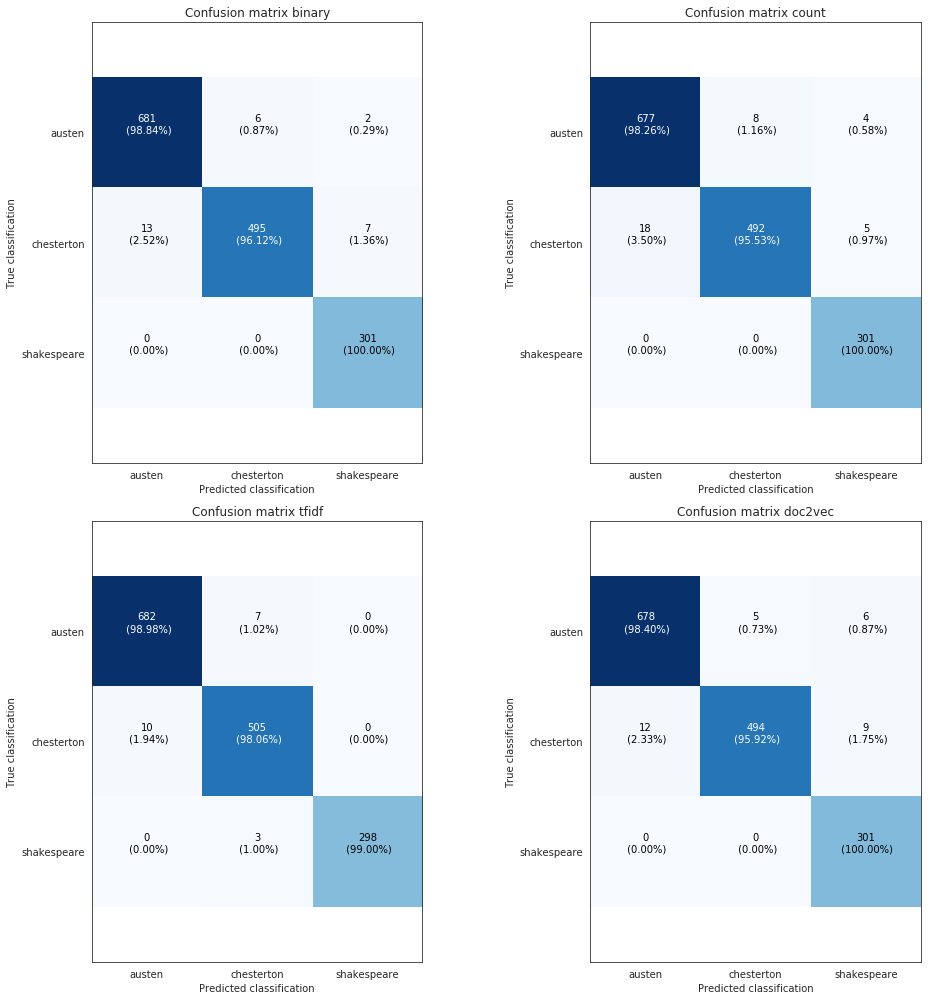

In [341]:
# Your code
import itertools
from sklearn.metrics import confusion_matrix

sns.set_style("white")


# Plotting the confusion matrix. (Code mainly from scikitlearn
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

    cm_normed = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)#, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd') + '\n ({:.2f}%)'.format(cm_normed[i,j]*100),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True classification')
    plt.xlabel('Predicted classification')
    plt.tight_layout()
    axes = plt.gca()
    bottom, top = axes.get_ylim()
    axes.set_ylim(bottom + 0.5, top - 0.5)



labels = ['austen', 'chesterton', 'shakespeare']

# use sklearn.metrics to get confusion matrices for all models
binary_cm = confusion_matrix(label_test, prediction_binary, labels=labels)
count_cm = confusion_matrix(label_test, prediction_count, labels=labels)
tfidf_cm = confusion_matrix(label_test, prediction_tfidf, labels=labels)
doc2vec_cm = confusion_matrix(label_test, prediction_doc2vec, labels=labels)


plt.figure(figsize=(14, 14))
plt.subplot(2,2,1)
plot_confusion_matrix(binary_cm, labels, title='Confusion matrix binary')
plt.subplot(2,2,2)
plot_confusion_matrix(count_cm, labels, title='Confusion matrix count')
plt.subplot(2,2,3)
plot_confusion_matrix(tfidf_cm, labels, title='Confusion matrix tfidf')
plt.subplot(2,2,4)
plot_confusion_matrix(doc2vec_cm, labels, title='Confusion matrix doc2vec')
plt.show()


(g) Obtain accuracy and f1-score for the four different models.


In [332]:
# Your code
from sklearn.metrics import accuracy_score, f1_score

print('Model \t \t Accuracy \t F1 score')
print('Binary: \t {:.4f} \t {:.4f}'.format(accuracy_score(label_test, prediction_binary),
                                           f1_score(label_test, prediction_binary, average='weighted')))

print('Count: \t \t {:.4f} \t {:.4f}'.format(accuracy_score(label_test, prediction_count),
                                             f1_score(label_test, prediction_count, average='weighted')))

print('Tf-Idf: \t {:.4f} \t {:.4f}'.format(accuracy_score(label_test, prediction_tfidf),
                                           f1_score(label_test, prediction_tfidf, average='weighted')))

print('Doc2Vec: \t {:.4f} \t {:.4f}'.format(accuracy_score(label_test, prediction_doc2vec),
                                            f1_score(label_test, prediction_doc2vec, average='weighted')))

Model 	 	 Accuracy 	 F1 score
Binary: 	 0.9814 	 0.9813
Count: 	 	 0.9767 	 0.9767
Tf-Idf: 	 0.9867 	 0.9867
Doc2Vec: 	 0.9787 	 0.9787


(h) Briefly comment on the quality of the predictions for the four models.

Explanation:

All models achieve both a very high prediction accuracy and F1 score (>0.97).
    
The most accurate prediction is the Tf-idf model, the least accurate is the model which was trained on the counted document-term matrix. One has to emphasize that all four results are very close to each other, though.
Surprisingly, the binary document-term matrix model is more accurate than the model with counts. Also the comparably poor performance of the Doc2Vec is surprising and might be due to the training of the model. (Dimension of the document vector was set to 300.)
    
Looking at the confusion matrix it is very clear, that Shakespeare documents are the easiest to classify. This is probably due to the fact that Shakespeare lived earlier, when the english language used a few different words and linguistic styles. Chesterton is the most difficult author to predict.


(i) For the two authors Austen and Chesterton separately, build a bigram language model. You should use both training and test data to build the model. Do not perform stemming or stopword removal for this task, but do use the other preprocessing steps described in (a). Use both right and left padding, and manage unknown terms by using a dedicated token.

In [343]:
# Your code
from nltk.lm import MLE
from nltk.lm.preprocessing import padded_everygram_pipeline

# loading both train and test set, concatenating them
path_train = 'datasets/pg_train.csv'
path_test = 'datasets/pg_test.csv'
corpus_train = pd.read_csv(path_train, sep='#', names=['Author', 'Text'], encoding='latin-1')
corpus_test = pd.read_csv(path_test, sep='#', names=['Author', 'Text'], encoding='latin-1')
corpus_total = pd.concat((corpus_train, corpus_test), axis=0)

# making separate dataframes for austen and chesterton
corpus_austen = corpus_total[corpus_total['Author'] == 'austen']
corpus_chesterton = corpus_total[corpus_total['Author'] == 'chesterton']

# Tokenization/Bag of Words Model -> Document-Term matrix
# here we tokenize, remove punctuation and convert uppercase to lowercase letters NO stemming, stopword removal
def tokenize2(doc):
    tokens = nltk.word_tokenize(doc.lower().translate(doc.maketrans('','',string.punctuation)))
    return tokens

austen = []
for doc in corpus_austen.iloc[:, 1]:
    austen.append(tokenize2(doc))

chesterton = []
for doc in corpus_chesterton.iloc[:, 1]:
    chesterton.append(tokenize2(doc))

# padded_everygram_pipeline uses left and right padding, as well as turning unknown tokens into "UNK"    
n = 2
train_data_austen, padded_sents_austen = padded_everygram_pipeline(n, austen)
train_data_chesterton, padded_sents_chesterton = padded_everygram_pipeline(n, chesterton)

model_austen = MLE(n)
model_chesterton = MLE(n)

# training the MLEs
model_austen.fit(train_data_austen, padded_sents_austen)
model_chesterton.fit(train_data_chesterton, padded_sents_chesterton)
print('Austen MLE model\'s vocabulary:')
print(model_austen.vocab, '\n')
len_austen = len(model_austen.vocab)
len_chesterton = len(model_chesterton.vocab)
print('Size of vocabulary: '+str(len_austen)+'.\n'
      'Training dimensions in bigram: '+str(len_austen)+'**2 = '+str(len_austen**2), '\n')
print('Chesterton MLE bigram model\'s vocabulary:')
print(model_chesterton.vocab)
print('Size of vocabulary: '+str(len_chesterton)+'.\n'
      'Training dimensions in bigram: '+str(len_chesterton)+'**2 = '+str(len_chesterton**2))

Austen MLE model's vocabulary:
<Vocabulary with cutoff=1 unk_label='<UNK>' and 10382 items> 

Size of vocabulary: 10382.
Training dimensions in bigram: 10382**2 = 107785924 

Chesterton MLE bigram model's vocabulary:
<Vocabulary with cutoff=1 unk_label='<UNK>' and 13239 items>
Size of vocabulary: 13239.
Training dimensions in bigram: 13239**2 = 175271121


(j) For each author, use the correspondent language models from (i) to generate, using MLE, a sentence of fifteen words starting from each of the following terms:

In [344]:
print('Austen bigram model 15 words sentences starting with "She", "They" and "It":')
print('She ' + ' '.join([str(word) for word in model_austen.generate(15, random_seed=394943, text_seed='She')]))
print('They ' + ' '.join([str(word) for word in model_austen.generate(15, random_seed=394943, text_seed='They')]))
print('It ' + ' '.join([str(word) for word in model_austen.generate(15, random_seed=394943, text_seed='It')]))
print('\n')
print('Chesterton bigram model 15 words sentences starting with "She", "They" and "It":')
print('She ' + ' '.join([str(word)+' ' for word in model_chesterton.generate(15, random_seed=394943, text_seed='She')]))
print('They ' + ' '.join([str(word)+' ' for word in model_chesterton.generate(15, random_seed=394943, text_seed='They')]))
print('It ' + ' '.join([str(word)+' ' for word in model_chesterton.generate(15, random_seed=394943, text_seed='It')]))

Austen bigram model 15 words sentences starting with "She", "They" and "It":
She was quite quick in the present powers or saw only source of sensibility speaking plain
They rational or saw only source of sensibility speaking plain my mother s notice or saw
It speak so painful than she saw only source of sensibility speaking plain my mother s


Chesterton bigram model 15 words sentences starting with "She", "They" and "It":
She nutt  put  so  said  the  professor  s  pond  the  professor  s  pond  the  professor  s 
They said  the  professor  s  pond  the  professor  s  pond  the  professor  s  pond  the  professor 
It spread  so  said  the  professor  s  pond  the  professor  s  pond  the  professor  s  pond 


(k) Now, computer another two models (for Austen and Chesterton separately), build a trigram model with the same data as in (i). Use both right and left padding, and manage unknown terms by using a dedicated token.

In [345]:
# Your code
# padded_everygram_pipeline uses left and right padding, as well as turning unknown tokens into "UNK"    
n = 3
train_data_austen3, padded_sents_austen3 = padded_everygram_pipeline(n, austen)
train_data_chesterton3, padded_sents_chesterton3 = padded_everygram_pipeline(n, chesterton)

trigram_model_austen = MLE(n)
trigram_model_chesterton = MLE(n)

# training the MLEs
trigram_model_austen.fit(train_data_austen3, padded_sents_austen3)
trigram_model_chesterton.fit(train_data_chesterton3, padded_sents_chesterton3)
print('Austen MLE trigram model\'s vocabulary:')
print(trigram_model_austen.vocab, '\n')
len_austen = len(trigram_model_austen.vocab)
len_chesterton = len(trigram_model_chesterton.vocab)
print('Size of vocabulary: '+str(len_austen)+'.\n'
      'Training dimensions in trigram: '+str(len_austen)+'**3 = '+str(len_austen**3), '\n')
print('Chesterton MLE trigram model\'s vocabulary:')
print(trigram_model_chesterton.vocab)
print('Size of vocabulary: '+str(len_chesterton)+'.\n'
      'Training dimensions in trigram: '+str(len_chesterton)+'**3 = '+str(len_chesterton**3))

Austen MLE trigram model's vocabulary:
<Vocabulary with cutoff=1 unk_label='<UNK>' and 10382 items> 

Size of vocabulary: 10382.
Training dimensions in trigram: 10382**3 = 1119033462968 

Chesterton MLE trigram model's vocabulary:
<Vocabulary with cutoff=1 unk_label='<UNK>' and 13239 items>
Size of vocabulary: 13239.
Training dimensions in trigram: 13239**3 = 2320414370919


(l) For each author, use the correspondent language models from (k) to generate, using MLE, a sentence of fifteen words starting from each of the same terms as question (j):

In [346]:
# Your code
print(len(trigram_model_austen.vocab), len(trigram_model_austen.vocab)**3)

print('Austen trigram model 15 words sentences starting with "She", "They" and "It":')
print('She ' + ' '.join([str(word) for word in trigram_model_austen.generate(15, random_seed=394943, text_seed='She')]))
print('They ' + ' '.join([str(word) for word in trigram_model_austen.generate(15, random_seed=394943, text_seed='They')]))
print('It ' + ' '.join([str(word) for word in trigram_model_austen.generate(15, random_seed=394943, text_seed='It')]))
print('\n')
print('Chesterton trigram model 15 words sentences starting with "She", "They" and "It":')
print('She ' + ' '.join([str(word) for word in trigram_model_chesterton.generate(15, random_seed=394943, text_seed='She')]))
print('They ' + ' '.join([str(word) for word in trigram_model_chesterton.generate(15, random_seed=394943, text_seed='They')]))
print('It ' + ' '.join([str(word) for word in trigram_model_chesterton.generate(15, random_seed=394943, text_seed='It')]))

10382 1119033462968
Austen trigram model 15 words sentences starting with "She", "They" and "It":
She was evidently struggling for composure elinor watched his eyes to the point of reading she
They put off the subject of mrs jennings should want him to make out from mrs
It speak sure you will not mention no particular gratitude which you so very obliging of


Chesterton trigram model 15 words sentences starting with "She", "They" and "It":
She nutt as miss barlow rattled it down to the police station which i implore you
They s pond the paragraph went on the road serious he cried they are right said
It spread to the police station which i implore you to howl in for the park


(m) Comment on the quality of the models and generated text. Which model performs better? In general, which differences are there in using trigrams as opposed to bigrams?

Explanation:

Looking at the quality of text provided by the two models, it is relatively obvious that the trigram MLE provides better text. It reads pretty fluently and is grammatically not bad (for an algorithm!!!).

The trigram was expected to perform better, as it is trained not only using token tuples of length 2 as the bigram, but using token tuples of length 3. This provides the model with a lot more contextual data enabling it to create text with more grammatical correctness and sense.

Generally, training a bigram is computationally less expensive. As computed and shown above, if a bigram is trained with a vocabulary of around 10000 tokens, it is trained with a training set of 10000^2 dimensions, while the trigram generates 10000^3 dimensions!

## Question 6 - Process Mining (15 points)
For this part, refer to the online docs of pm4py (https://pm4py.fit.fraunhofer.de/).
Important: if you did not do it in the instruction, you should make sure to have the latest pm4py version: to get it is sufficient to type `pip install pm4py --upgrade`.
In this section of the assignment you will be working with a real life event log, derived from the activity of the help desk department of an Italian software company. The data is contained in the file "event_log.xes".

(a) Use the provided event log and identify the least frequent variant and the most frequent variant.


In [348]:
# Your code
from pm4py.objects.log.importer.xes import factory as xes_importer
from pm4py.objects.log.util import sorting
from pm4py.statistics.traces.log import case_statistics

# import event log
log_path = 'datasets/event_log.xes'
log = xes_importer.import_log(log_path)
print('Length of log file: ', len(log))
log = sorting.sort_timestamp(log)

# Checking traces
variants_count = case_statistics.get_variant_statistics(log)
variants_count = sorted(variants_count, key=lambda x: x['count'], reverse=True)
most_freq_variants = case_statistics.get_variant_statistics(log, parameters={"max_variants_to_return": 3})
print('To see if there are multiple variants with the greatest frequency, we print the'
      'top three most frequent variants:')
print(most_freq_variants)
print(' ')
print('The most frequent variant (2366 counts) is:\n', most_freq_variants[0]['variant'])
print(' ')
print('Number of variants: ', len(variants_count))
print('Number of variants of frequency 1: ', 
      len([variant for variant in variants_count if variant['count'] == 1]), '\n')

print('Since there are 135 different least frequent variants, we are only goint to print 5 of them:\n'
      ' (The other are stored in the list "least_freq_variants")')
least_freq_variants = [variant for variant in variants_count if variant['count'] == 1]
print('\n'.join([variant['variant'] for variant in least_freq_variants[:5]]))

Length of log file:  4580
To see if there are multiple variants with the greatest frequency, we print thetop three most frequent variants:
[{'variant': 'Assign seriousness,Take in charge ticket,Resolve ticket,Closed', 'count': 2366}, {'variant': 'Assign seriousness,Take in charge ticket,Wait,Resolve ticket,Closed', 'count': 552}, {'variant': 'Assign seriousness,Take in charge ticket,Wait,Take in charge ticket,Resolve ticket,Closed', 'count': 228}]
 
The most frequent variant (2366 counts) is:
 Assign seriousness,Take in charge ticket,Resolve ticket,Closed
 
Number of variants:  226
Number of variants of frequency 1:  135 

Since there are 135 different least frequent variants, we are only goint to print 5 of them:
 (The other are stored in the list "least_freq_variants")
Wait,Resolve ticket,Closed
Take in charge ticket,Wait,Wait,Resolve ticket,Closed
Take in charge ticket,Wait,Resolve ticket,Take in charge ticket,Wait,Resolve ticket,Closed
Take in charge ticket,Take in charge ticket,Ta

(b) Remove all the variants that contain less than 1% of the traces in the log. Create a new event log without these variants.

In [349]:
# Your code
from pm4py.algo.filtering.log.variants import variants_filter

num_traces = 0.01 * len(log)
print('Minimum number of traces a variant has to contain: ', str(np.ceil(num_traces)))

# creating a list containing all the valid traces
variants = [var['variant'] for var in variants_count if var['count'] > num_traces]
print('Number of variants in the filtered log: ', str(len(variants)))

# creating a log, using the 
filtered_log = variants_filter.apply(log, variants)
f2_variants_count = case_statistics.get_variant_statistics(filtered_log)
print('Number of cases in the filtered log: ', str(len(filtered_log)))


Minimum number of traces a variant has to contain:  46.0
Number of variants in the filtered log:  9
Number of cases in the filtered log:  3811


(c) Use Inductive miner algorithm to discover the process model based on you new event log (the filtered log without the infrequent variants of question (b)).


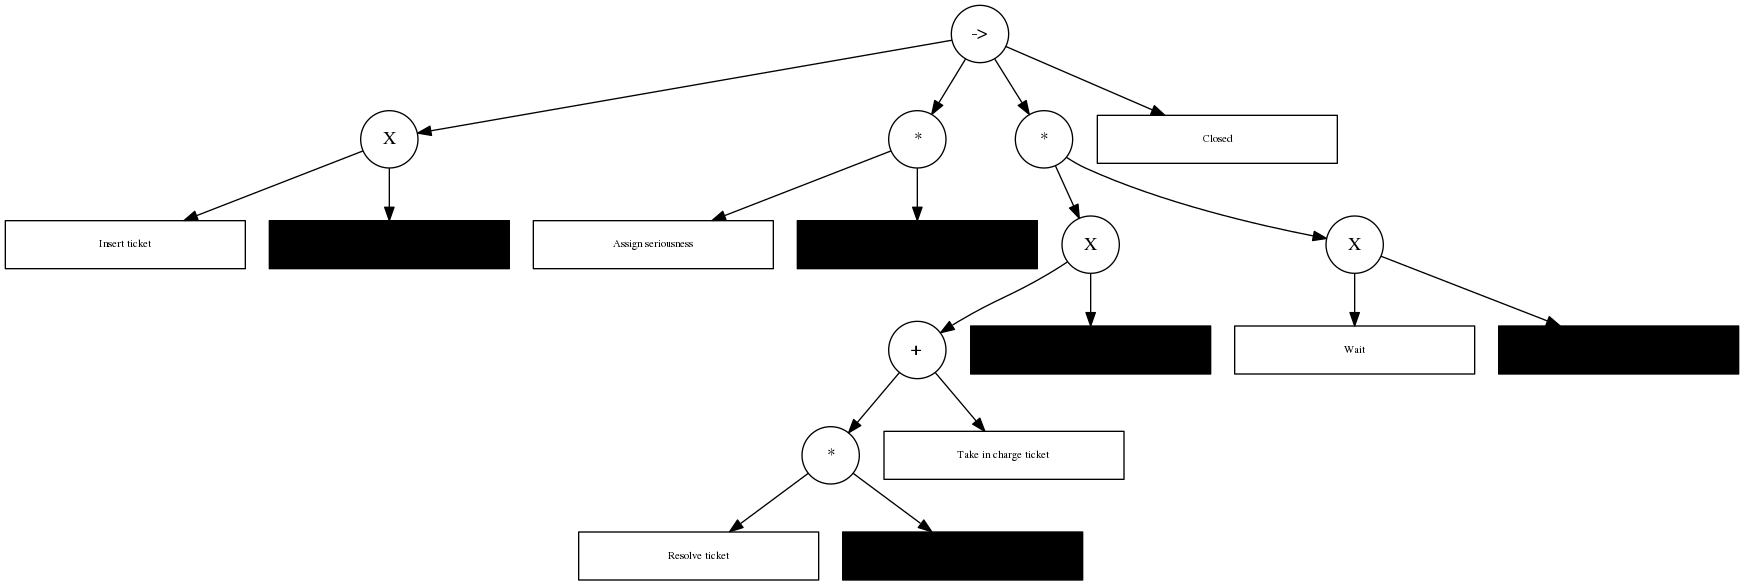

In [350]:
# Your code
from pm4py.algo.discovery.inductive import factory as inductive_miner
from pm4py.visualization.process_tree import factory as pt_vis_factory
from pm4py.algo.discovery.dfg import factory as dfg_factory
from pm4py.visualization.dfg import factory as dfg_vis_factory

# create inductive miner model from log
tree = inductive_miner.apply_tree(filtered_log)

# visualize the model
gviz_tree = pt_vis_factory.apply(tree)
pt_vis_factory.view(gviz_tree)

(d) Perform the token replay conformance checking using your discovered model (c) and the original event log. Does your process model fit the log?


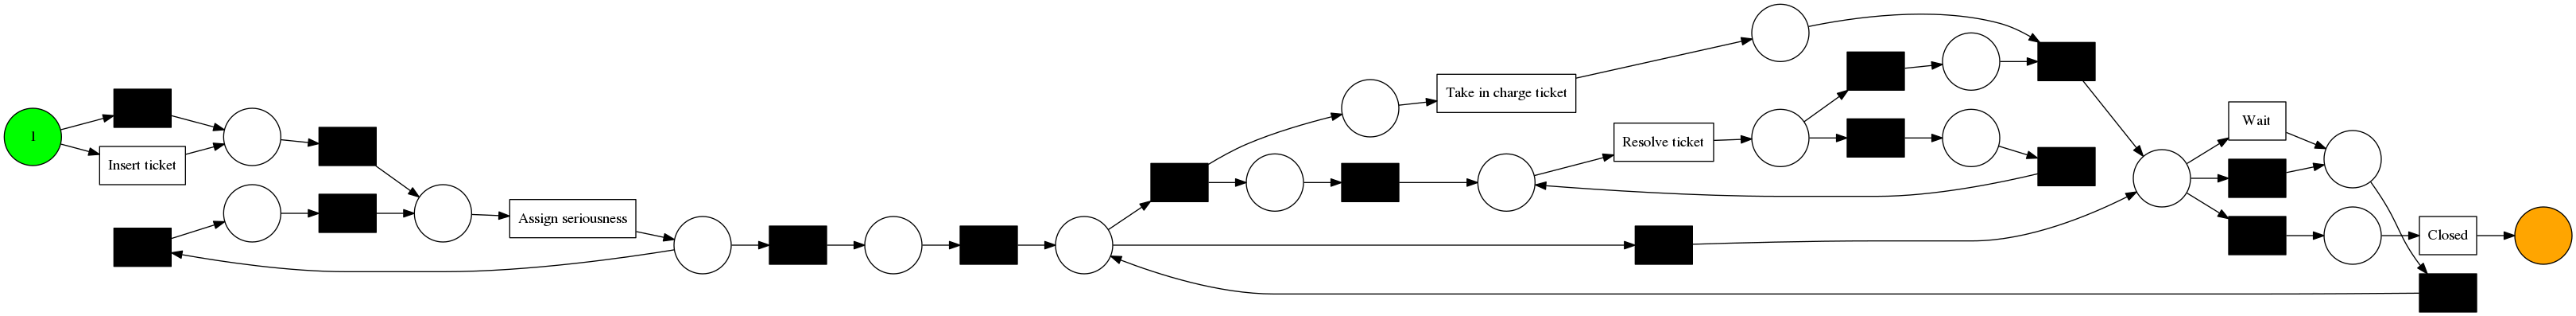

{'trace_is_fit': False, 'trace_fitness': 0.9375, 'activated_transitions': [skip_1, init_loop_2, Assign seriousness, skip_5, init_loop_6, tauSplit_8, Take in charge ticket, init_loop_10, Resolve ticket, skip_13, tauJoin_9, skip_16, Closed, Closed], 'reached_marking': ['sink:2'], 'enabled_transitions_in_marking': set(), 'transitions_with_problems': [Closed], 'missing_tokens': 1, 'consumed_tokens': 16, 'remaining_tokens': 1, 'produced_tokens': 16}

 2989  out of  4580  traces in the original event log fit the model.



In [351]:
# Your code
from pm4py.algo.conformance.tokenreplay import factory as token_based_replay_factory
from pm4py.evaluation.replay_fitness import factory as replay_fitness_factory
from pm4py.visualization.petrinet import factory as pn_vis_factory

# create petri net from inductive miner model and plot
net_most, initial_marking_most, final_marking_most = inductive_miner.apply(filtered_log)
gviz_pn = pn_vis_factory.apply(net_most, initial_marking_most, final_marking_most)
pn_vis_factory.view(gviz_pn)

# doing the token-based replay
tbr_result = token_based_replay_factory.apply(log, net_most, initial_marking_most, final_marking_most)
tbr_filtered_result = token_based_replay_factory.apply(filtered_log, net_most, initial_marking_most, final_marking_most)
print(tbr_result[0])

counter = 0
for trace in tbr_result:
    if trace['trace_is_fit']:
        counter += 1
print('\n', counter, ' out of ', len(tbr_result), ' traces in the original event log fit the model.\n')


Explanation:

Model fitness quantifies the extent in which the resulting model can reproduce the behavior in the log.

(e) Calculate the fitness of the model in (c).

In [352]:
# Your code
print('The question is a little unclear and relatively similar to the explanation in d). We understand it in '
      'a way, that we are supposed to calculate the fitness of the model given the original event log.')

fitness_tbr = replay_fitness_factory.apply(log, net_most, initial_marking_most, final_marking_most)

print('Fitness of the model:')
print(fitness_tbr)

The question is a little unclear and relatively similar to the explanation in d). We understand it in a way, that we are supposed to calculate the fitness of the model given the original event log.
Fitness of the model:
{'percFitTraces': 62.99126637554585, 'averageFitness': 0.9387764189103075}


(f) Are there any deviations between the process model and the event log? If so, where and why?

Explanation:

Yes, there are deviations, as the least frequent traces are not used to create the model, but are included in computing the fitness. Therefore, it is obvious that the model fitness does not take on a perfect score.

An example is the trace 'Wait,Resolve ticket,Closed', which was printed in a) and excluded from the event log by the filtering. Or all the traces which start with the event 'Take in charge ticket'. The inductive miner created in c) only allows 'Insert ticket' or 'Assign seriousness' to be the starting activity.

(g) Now use the original event log and remove the two most frequent variants, and discover the model based on your new event log (the filtered log without two most frequent variants).


Number of variants in the filtered log:  224
Number of cases in the filtered log:  1662


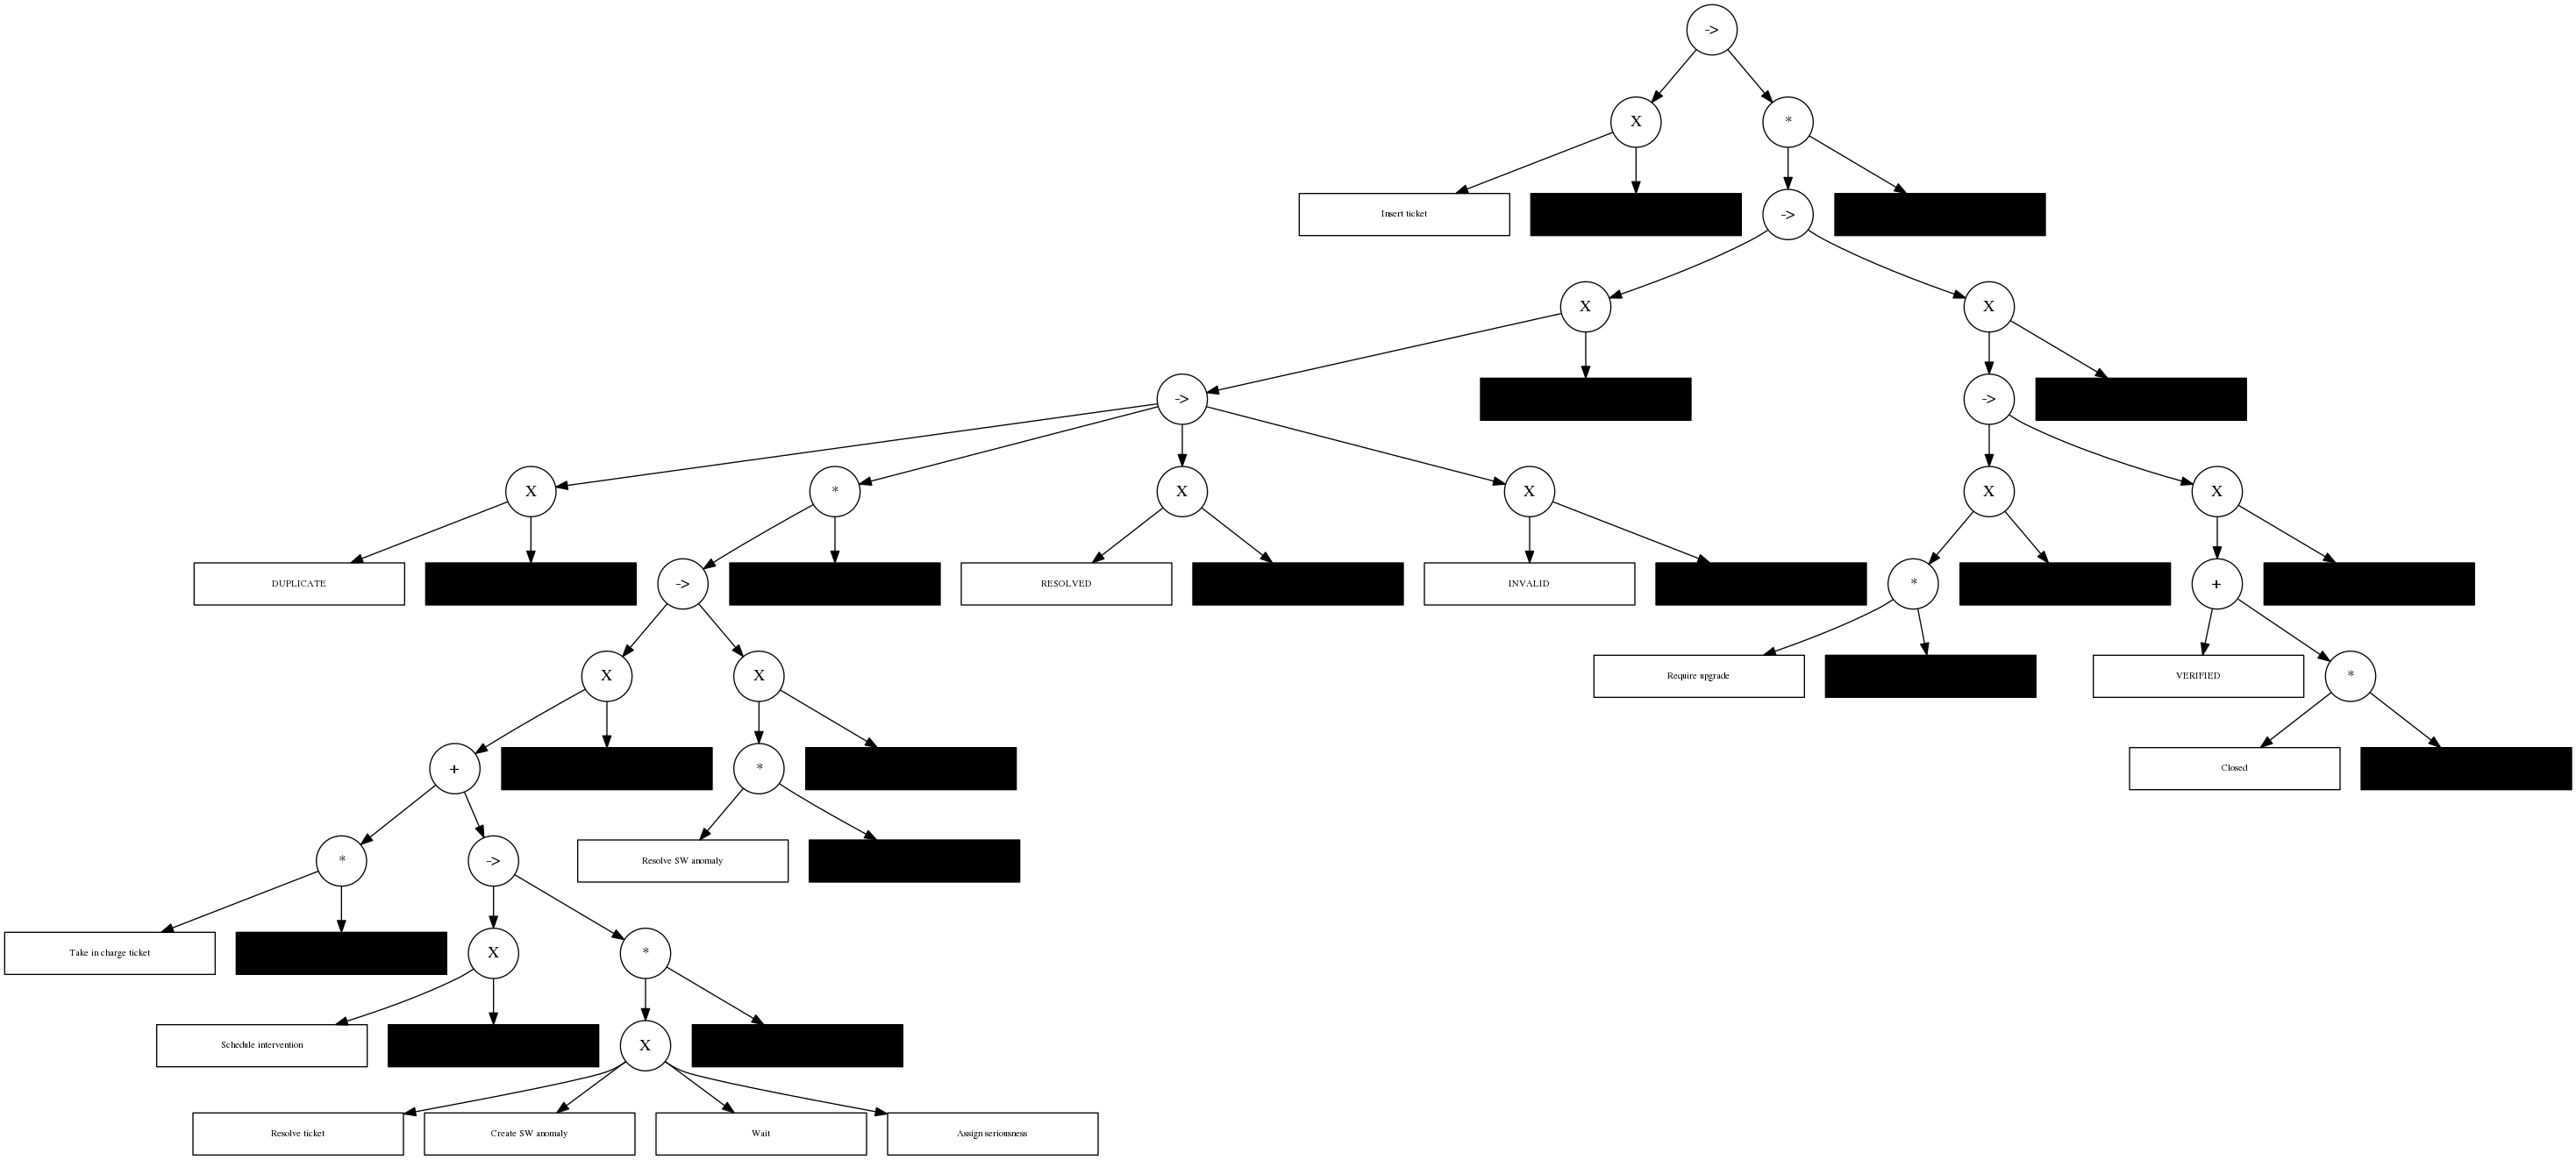

In [353]:
# Your code
# creating a list containing all the valid traces
allowed_variants = [var['variant'] for var in variants_count][2:]
print('Number of variants in the filtered log: ', str(len(allowed_variants)))

# creating a log, using the 
filtered2_log = variants_filter.apply(log, allowed_variants)
filtered2_variants_count = case_statistics.get_variant_statistics(filtered2_log)
print('Number of cases in the filtered log: ', str(len(filtered2_log)))

# create inductive miner model from log
tree2 = inductive_miner.apply_tree(filtered2_log)

# visualize the model
gviz_tree2 = pt_vis_factory.apply(tree2)
pt_vis_factory.view(gviz_tree2)

(h) Perform the token replay conformance checking using the newly discovered model of question (g) and the original event log. Does your process model fit the log?

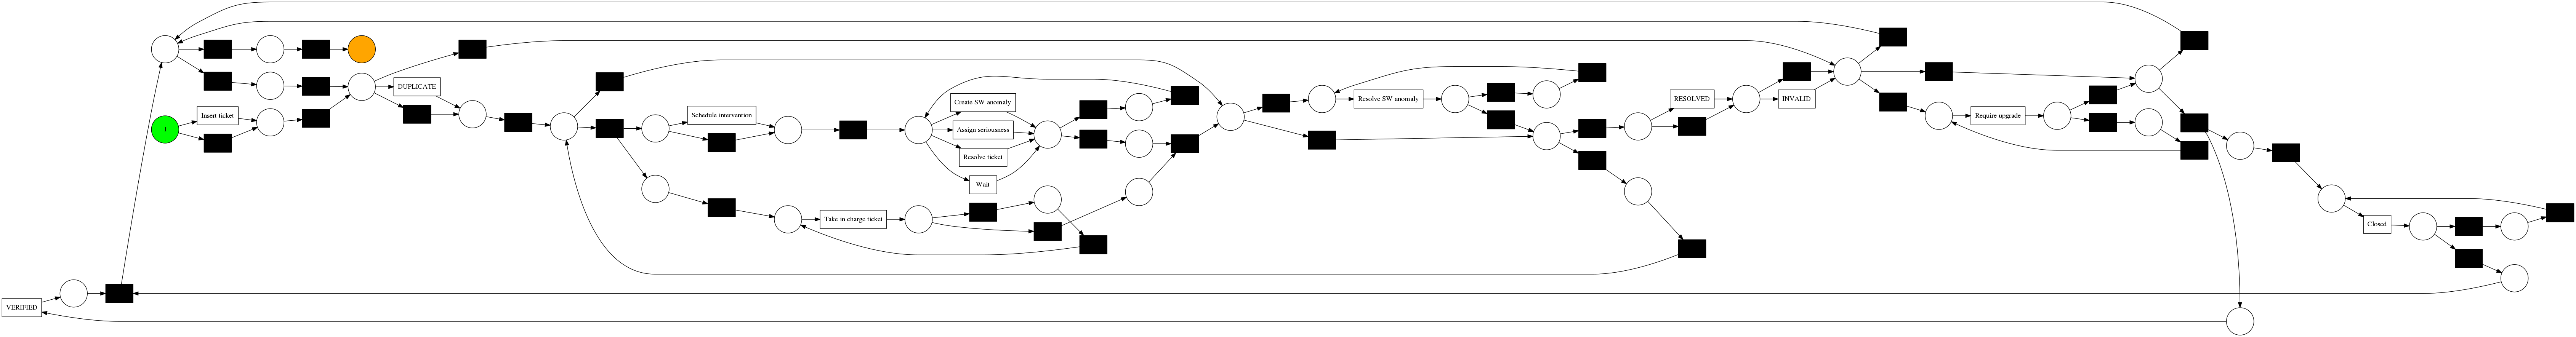


 4204  out of  4580  traces in the original event log fit the new model.



In [354]:
# Your code
# create petri net from inductive miner model and plot
net_most2, initial_marking_most2, final_marking_most2 = inductive_miner.apply(filtered2_log)
gviz_pn2 = pn_vis_factory.apply(net_most2, initial_marking_most2, final_marking_most2)
pn_vis_factory.view(gviz_pn2)

# doing the token-based replay
tbr2_result = token_based_replay_factory.apply(log, net_most2, initial_marking_most2, final_marking_most2)

counter = 0
for trace in tbr2_result:
    if trace['trace_is_fit']:
        counter += 1
print('\n', counter, ' out of ', len(tbr2_result), ' traces in the original event log fit the new model.\n')

Explanation:

This time, even 4204 out of the 4580 traces in the original event log fit the model (compared to the 2989 of the first model). This is possible, since the created model both fits the two most frequent traces 
- 'Assign seriousness,Take in charge ticket,Resolve ticket,Closed'
- 'Assign seriousness,Take in charge ticket,Wait,Resolve ticket,Closed'

although they were not used to train the model. 


(i) Calculate the fitness of the model in (g).

In [355]:
# Your code
'''
fitness_tbr2 = replay_fitness_factory.apply(log, net_most2, initial_marking_most2, final_marking_most2)
'''
print('The first line of code unfortunately does give a result, as the computation does not finish'
      '/takes way too long. We therefore calculate the trace average fitness by hand.')

averageFitness = np.mean([tbr['trace_fitness'] for tbr in tbr2_result])
print('Fitness of the second model:')
print(averageFitness)

The first line of code unfortunately does give a result, as the computation does not finish/takes way too long. We therefore calculate the trace average fitness by hand.
Fitness of the second model:
0.9605770305521191


(j) Are there any deviations in the process model? If so, where and why?

Explanation:

Yes, there must be deviations, since the average trace fitness is 0,961. No deviations would result in an average fitness of 1,0.

However, this result is astonishing. One great property of the Inductive Miner algorithm is that it guarantees that the original event log can be replayed. As already shown in Q6 h), both most frequent variant do fit the model. Therefore, the average fitness should be 1,0.

The only way this can be possible, is that small changes have been made in the pm4py.algo.discovery.inductive.factory implementation, maybe in order to make the algorithm faster.

(k) Use the complete event log (original event log) and discover your process model using Inductive Miner.


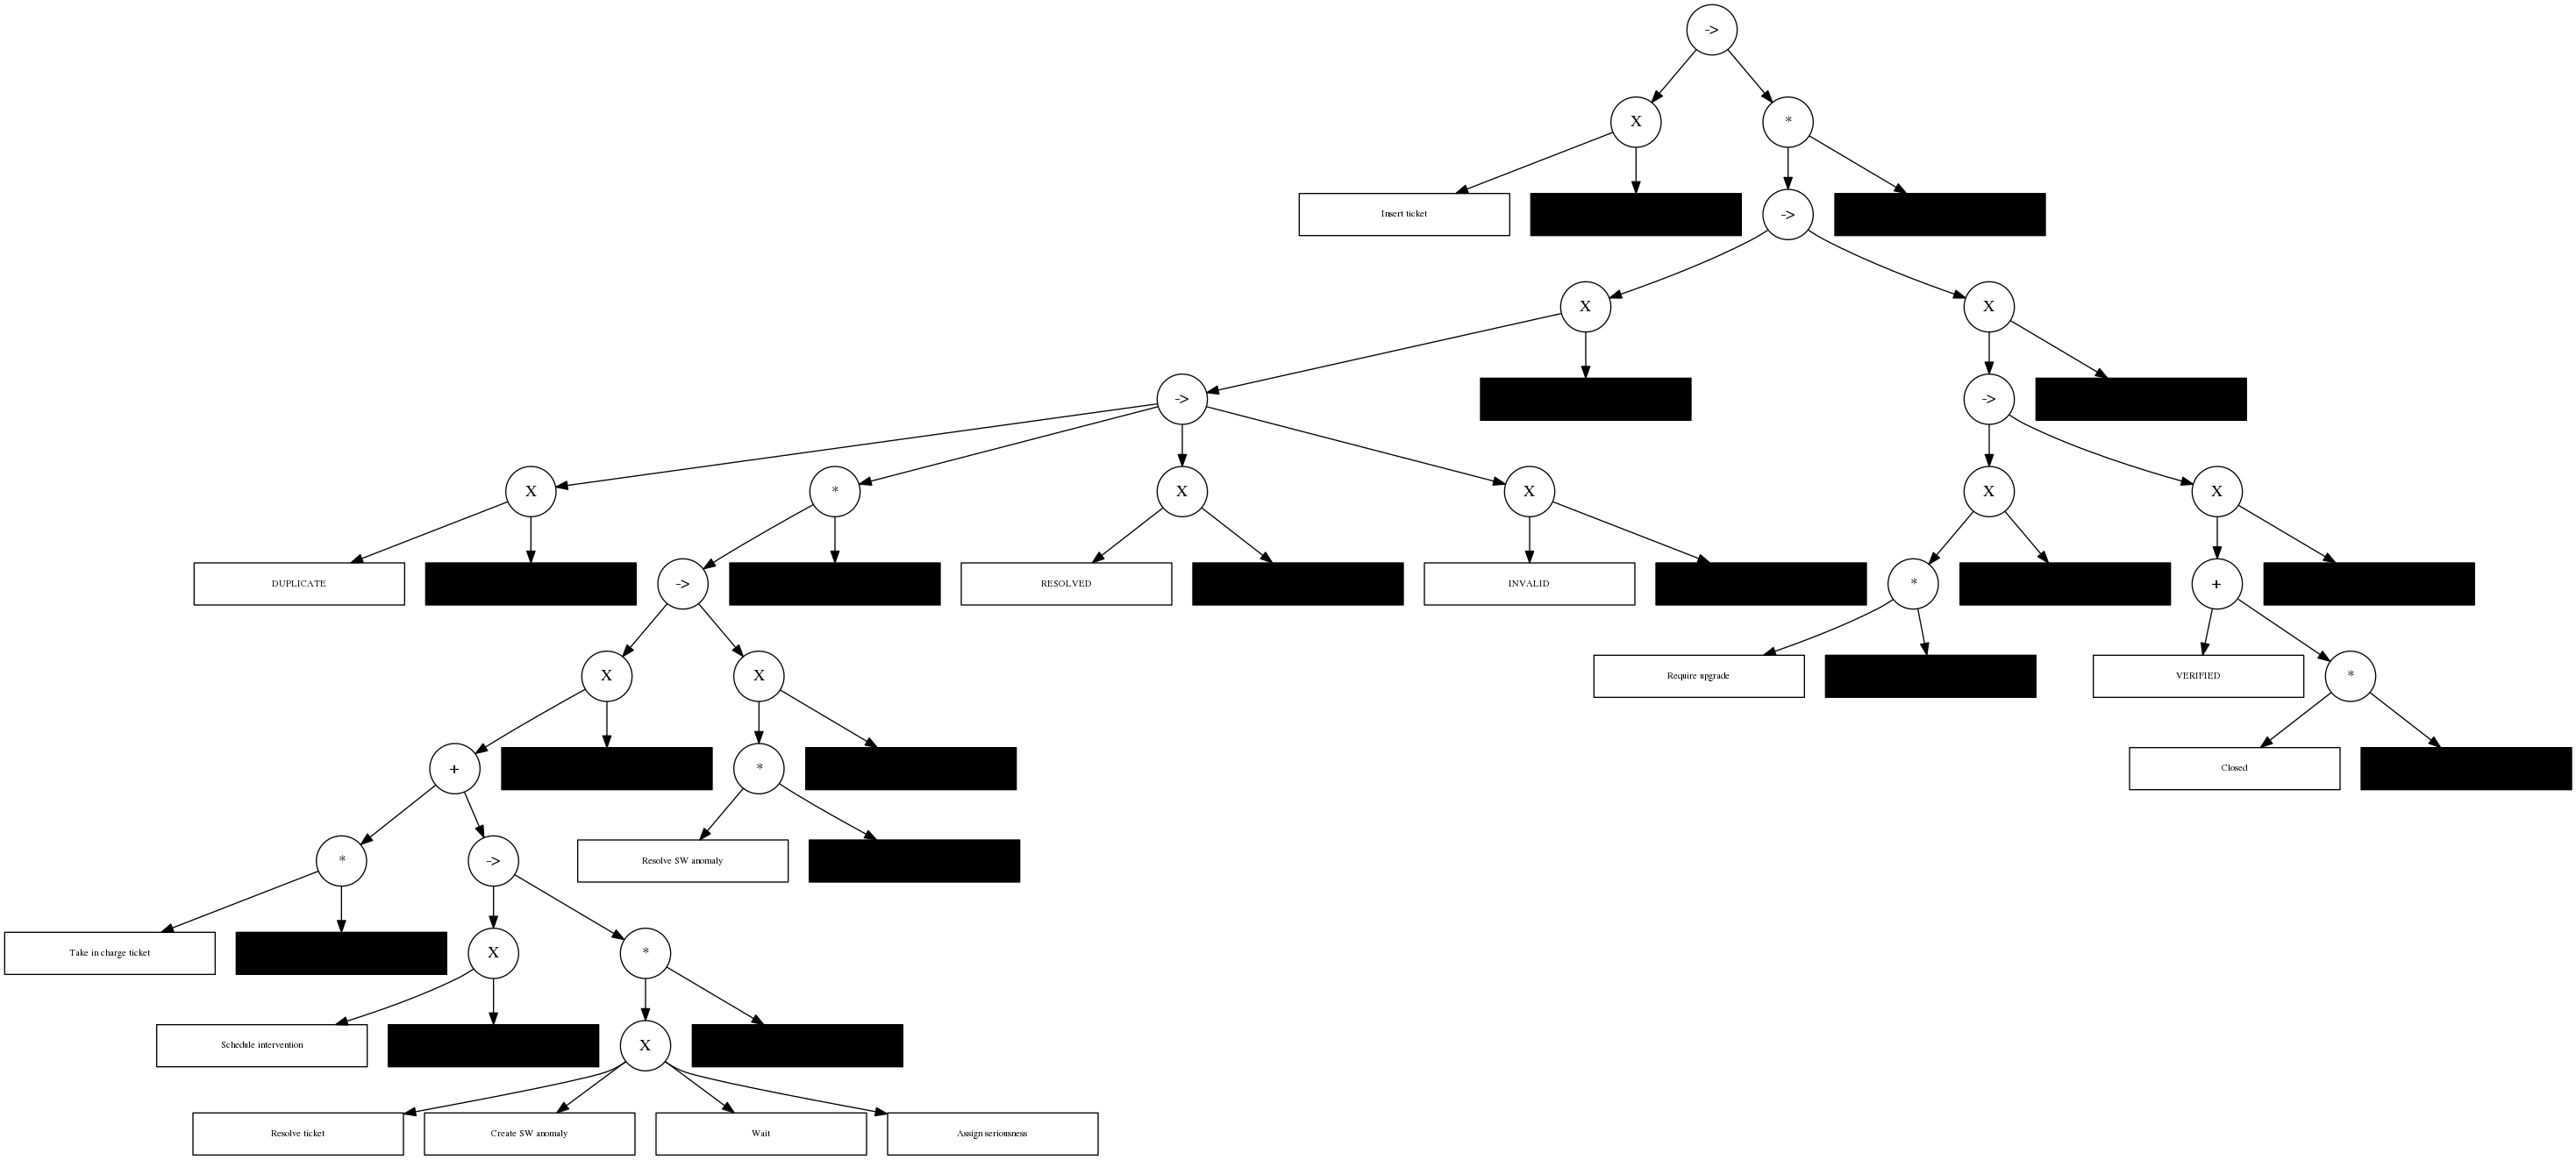

In [356]:
# Your code

# create inductive miner model from log
tree_nofilter = inductive_miner.apply_tree(log)

# visualize the model
gviz_tree_nofilter = pt_vis_factory.apply(tree_nofilter)
pt_vis_factory.view(gviz_tree_nofilter)

(l) Do the token replay conformance checking using your newly discovered model and the original event log. Does your process model fit the log?

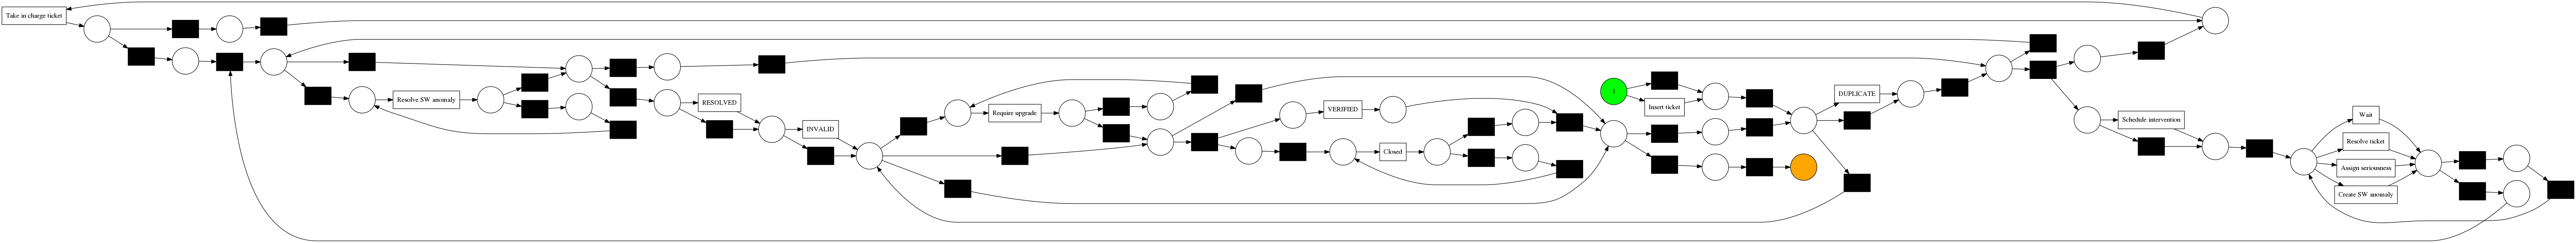


 4204  out of  4580  traces in the original event log fit this model.



In [357]:
# Your code

# create petri net from inductive miner model and plot
net_most_nofilter, initial_marking_most_nofilter, final_marking_most_nofilter = inductive_miner.apply(log)
gviz_pn_nofilter = pn_vis_factory.apply(net_most_nofilter, 
                                        initial_marking_most_nofilter,
                                        final_marking_most_nofilter)
pn_vis_factory.view(gviz_pn_nofilter)

# doing the token-based replay
tbr_nofilter_result = token_based_replay_factory.apply(log, net_most_nofilter, 
                                                       initial_marking_most_nofilter,
                                                       final_marking_most_nofilter)
counter = 0
for trace in tbr_nofilter_result:
    if trace['trace_is_fit']:
        counter += 1
print('\n', counter, ' out of ', len(tbr_nofilter_result), ' traces in the original event log fit this model.\n')

Explanation:

As expected, this model fits the event log in exact the same way as the model which was trained in g).

(m) How are these three discovered process models different from each other? Which model is the best fitting to the original log? Why?

In [358]:
averageFitness3 = np.mean([tbr['trace_fitness'] for tbr in tbr_nofilter_result])
print('Fitness of the second model:')
print(averageFitness3)

Fitness of the second model:
0.9605770305521191


Explanation:

As already stated, model 2 from g) and model 3 from k) are exactly the same. This is, because the two most frequent variants - which were not used to train model 2 - can still be replayed by the model. As these two variants are the only difference between the event log used for training model 2 and model 3, the resulting models are the same.

The average trace fitness of model 1 (0,94) is a little smaller than the average trace fitness of model 2/model 3, which score 0,96. Therefore, both model 2 and model 3 are the best fitting models to the event log. 

This is also logical, since the Inductive Miner is designed to perfectly the replay the log it was trained on. Hence, if all the data (in case of model 3) is used to train the model, then a perfect fitting model will be created.

However, this does not necessarily mean, that model 2 and model 3 are generally better than model 1. In order to assess the best overall model, other criteria like precision, generalization and simplicity also have to be taken into account.

(n) Visualize the model discovered in question (k) enriched with frequency information. Subsequently, visualize that same model enriched with performance information.

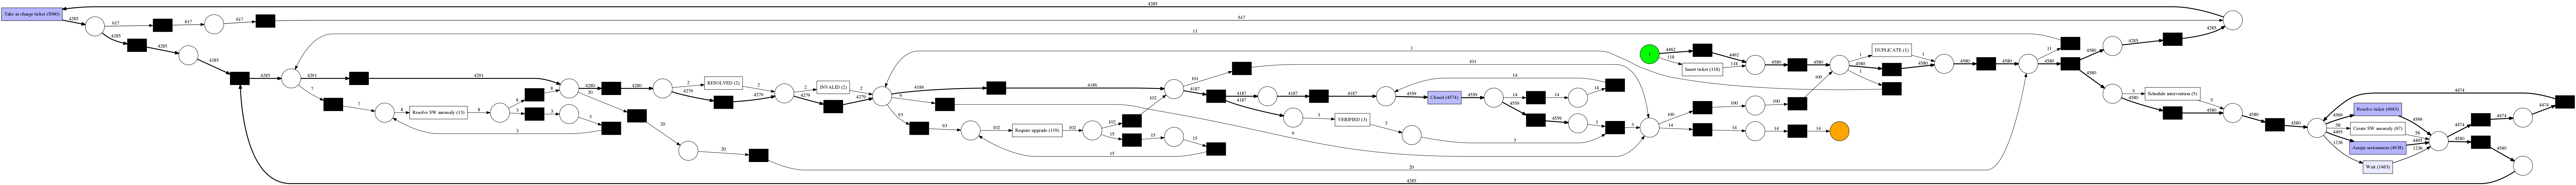

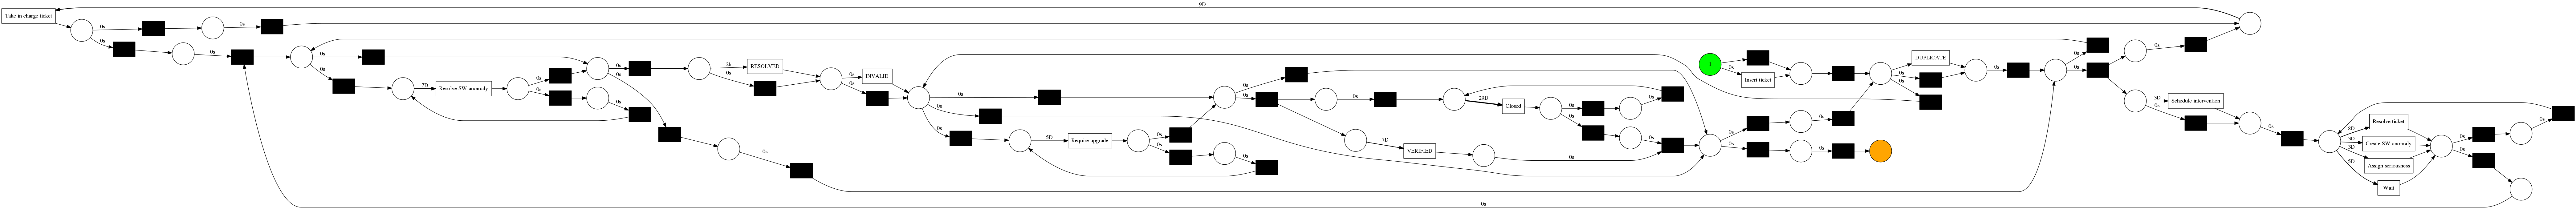

In [360]:
# Your code
# visualize the model

parameters = {"format":"png"}
gviz_pn_nofilter = pn_vis_factory.apply(net_most_nofilter, 
                                        initial_marking_most_nofilter,
                                        final_marking_most_nofilter)
gviz_freq = pn_vis_factory.apply(net_most_nofilter, 
                                 initial_marking_most_nofilter,
                                 final_marking_most_nofilter, 
                                 parameters=parameters, 
                                 variant="frequency", 
                                 log=log)

pt_vis_factory.view(gviz_freq)

gviz_perform = pn_vis_factory.apply(net_most_nofilter, 
                                    initial_marking_most_nofilter,
                                    final_marking_most_nofilter, 
                                    parameters=parameters, 
                                    variant="performance", 
                                    log=log)

pt_vis_factory.view(gviz_perform)

(o) If you were the process owner and you had more resources to hire employees, on which parts of the process would you assign them to maximize efficiency?

Explanation:

I would assign them to do activities which have a high frequency and also take a long time. This way, the company could maximize its efficiency. Unfortunately, the two figures plotted in n) are very hard to read, as they are so small. I therefore used the process mining software Disco to visualize the dataset and interpret the (directly-follows-graph) with frequencies and performance there.

In the following figure (taken from Disco), one can see a lot easier where employees could be used:

![disco_performance_frequency](figures/disco_performance_frequency.png)

The most frequent variant is 'Assign seriousness,take in charge ticket,resolve ticket,closed'. This is the variant that 2366 out of the total 4580 traces look like, which is 52%. Furthermore, looking at their frequencies, it becomes clear that also other traces pass these steps, since the frequencies range from 4159 to 4569. If you compare the three steps and especially their mean duration, one notices that the last step from 'resolve ticket -> closed' is taking three times as long as the steps beforehand. 

Therefore, we would first assign new employees to this task.

(p) Add your further comments and considerations on the frequency and performance informations. Does the process have a "happy path", and is it shown in the enhanced process models? Where are the major bottlenecks in this process? Is there any rework?

Explanation:

Some of these parts, we have already answered in the last question o). The 'happy path' is definitely the most frequent variant 'Assign seriousness,take in charge ticket,resolve ticket,closed'. The bottle is going from 'resolve ticket -> closed'. The following figure shows each paths total duration, which is the frequency multiplied by the mean duration.

![disco_totalduration.png](figures/disco_totalduration.png)

In order to find our if there is rework, I filter the log by looking if the activity 'take in charge ticket' is sometimes followed by itself, and if possible not immediately. If it was followed immediately there could have been a mistake and not necessarily rework.

As shown in the figure below, there are 623 cases in which 'take in charge ticket' happens more than one time. Only 84 times of the 623, the event is followed by itself. This means, that in 539 out of the 4580 cases, rework had to be done.

Of course, one could define rework differently. As we do not know the real activities of the help desk department in this italian company, and what is actually done during 'take in charge ticket', 'require update' or 'create sw anomaly', we can only make a best guess. 

![disco_filter_takeinchargeticket.png](figures/disco_filter.png)